# Bayesian Optimization Tutorial with GP Hyperparameter Tuning

This tutorial demonstrates how to:
1. Set up GP models with different hyperparameter priors
2. Run Bayesian optimization experiments
3. Visualize and analyze the results interactively

Written by - [Utkarsh Pratiush]()
## Setup and Imports

In [ ]:
#install
!pip install botorch==0.12.0
!pip install gpytorch==1.13

In [1]:
import torch
import gpytorch
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Tuple, List, Dict
import time
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.exceptions.errors import ModelFittingError

%matplotlib inline

## Model Definition

In [3]:
class GPModel(SingleTaskGP):
    """Custom GP model with configurable priors"""
    def __init__(self, train_X, train_Y, lengthscale_prior=None, noise_prior=None):
        #Because its better for cholesky decomposition--> double precision i.e float64
        train_X = train_X.to(dtype=torch.float64)
        train_Y = train_Y.to(dtype=torch.float64)
        covar_module = ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior))# Set priors
        likelihood = GaussianLikelihood(noise_prior=noise_prior)# Set priors
        super().__init__(train_X, train_Y, covar_module=covar_module, likelihood=likelihood)
    


## Test Functions

In [4]:
           
def generate_test_function(function_type: str, dim: int, **kwargs) -> Callable:
    """Generate synthetic test functions with built-in normalization"""
    def normalize_function(func):
        def normalized_func(x):
            x = x.to(dtype=torch.float64)# Convert input to double precision
            y = func(x)
            test_x = torch.linspace(0, 1, 100, dtype=torch.float64).reshape(-1, 1)# Compute normalization constants on a grid of points
            if dim == 2:
                grid_x, grid_y = torch.meshgrid(test_x.squeeze(), test_x.squeeze(), indexing='ij')
                test_x = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
            test_y = func(test_x)
            y_mean = test_y.mean()
            y_std = test_y.std()
            return (y - y_mean) / (y_std + 1e-8)
        return normalized_func

    if function_type == 'linear':
        if dim == 1:
            base_func = lambda x: (kwargs.get('slope', 1.0) * x + kwargs.get('intercept', 0.0)).unsqueeze(-1)
        else:
            base_func = lambda x: (kwargs.get('slope_x', 1.0) * x[..., 0] + kwargs.get('slope_y', 1.0) * x[..., 1] + kwargs.get('intercept', 0.0)).unsqueeze(-1)
    
    elif function_type == 'gaussian':
        if dim == 1:
            base_func = lambda x: (kwargs.get('amplitude', 1.0) * torch.exp(-((x - kwargs.get('center', 0.5)) ** 2) / (2 * kwargs.get('width', 0.25) ** 2))).unsqueeze(-1)
        else:
            base_func = lambda x: (
                kwargs.get('amplitude', 1.0) * torch.exp(
                    -((x[..., 0] - kwargs.get('center_x', 0.5)) ** 2) / (2 * kwargs.get('width_x', 0.25) ** 2)
                    -((x[..., 1] - kwargs.get('center_y', 0.5)) ** 2) / (2 * kwargs.get('width_y', 0.25) ** 2)
                )
            ).unsqueeze(-1)
    
    elif function_type == 'custom':
        if dim == 1:
            base_func = lambda x: (torch.sin(8 * np.pi * x) + 0.5 * torch.sin(16 * np.pi * x)).unsqueeze(-1)
        else:
            base_func = lambda x: (torch.sin(8 * np.pi * x[..., 0]) * torch.cos(8 * np.pi * x[..., 1])).unsqueeze(-1)
    
    else:
        raise ValueError(f"Unknown function type: {function_type}")
    
    return normalize_function(base_func)


## Bayesian Optimization Experiment

In [5]:

def run_bo_experiment(
    test_function: Callable,
    dim: int,
    n_initial: int = 5,
    n_iterations: int = 10,
    lengthscale_prior=None,
    noise_prior=None,
    noise_level: float = 0.05,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> Dict:
    """
    Run a Bayesian Optimization experiment

    """
    bounds = torch.stack([torch.zeros(dim, dtype=torch.float64), 
                         torch.ones(dim, dtype=torch.float64)]).to(device)# Generate initial training data with double precision
    
    soboleng = torch.quasirandom.SobolEngine(dimension=dim)# Initial points with double precision
    train_x = soboleng.draw(n_initial).to(dtype=torch.float64, device=device)
    
    true_y = test_function(train_x)
    train_y = true_y + noise_level * torch.randn_like(true_y, dtype=torch.float64)

    true_y = true_y.view(-1, 1)  # Convert to [N, 1]# # Ensure consistent dimensions for both 1D and 2D cases
    train_y = train_y.view(-1, 1)  # Convert to [N, 1]

    
    results = {
        "train_x": [train_x.clone()],
        "train_y": [train_y.clone()],
        "true_y": [true_y.clone()],
        "max_values": [true_y.max().item()],
        "best_observed": [true_y.max().item()],
        "lengthscales": [],
        "noise_variance": [],
        "time_taken": [],
    }
    
    for i in range(n_iterations):
        start_time = time.time()
        
        gp = GPModel(
            train_X=train_x, 
            train_Y=train_y,
            lengthscale_prior=lengthscale_prior,
            noise_prior=noise_prior
        )
        
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        
        try:
            fit_gpytorch_mll(mll)
        except ModelFittingError as e:
            print(f"Model fitting failed: {e}")
            print("Retrying with adjusted parameters...")
            gp.likelihood.noise_covar.noise = torch.tensor(1e-4).to(gp.likelihood.noise_covar.noise.device)
            fit_gpytorch_mll(mll)
        
        results["lengthscales"].append(gp.covar_module.base_kernel.lengthscale.item())# store hyperparameters
        results["noise_variance"].append(gp.likelihood.noise.item())
        
        beta = 1e6# manumum uncertainity
        UCB = UpperConfidenceBound(model=gp, beta=beta)
        
        try: # Optimize acquisition function with better initialization
            candidate, acq_value = optimize_acqf(
                acq_function=UCB,
                bounds=bounds,
                q=1,
                num_restarts=10,  # Increased from 5
                raw_samples=512,  # Increased from 20
                options={"batch_limit": 5, "maxiter": 200},
            )
        except Exception as e:
            print(f"Acquisition optimization failed, using random sampling: {e}")
            # Fallback to random sampling if optimization fails
            candidate = torch.rand(1, dim, device=device, dtype=torch.float64)
            candidate = bounds[0] + (bounds[1] - bounds[0]) * candidate
        
        new_x = candidate.detach()
        true_new_y = test_function(new_x)
        new_y = true_new_y + noise_level * torch.randn_like(true_new_y)
        
        true_new_y = true_new_y.view(-1, 1)
        new_y = new_y.view(-1, 1)
        
        train_x = torch.cat([train_x, new_x])
        train_y = torch.cat([train_y, new_y])
        
        
        results["train_x"].append(train_x.clone())
        results["train_y"].append(train_y.clone())
        results["true_y"].append(true_new_y.clone())
        results["max_values"].append(true_new_y.item())
        
        true_values = test_function(train_x)
        results["best_observed"].append(true_values.max().item())
        
        results["time_taken"].append(time.time() - start_time)
        
    return results

## Prior Configurations

In [6]:

def get_prior_configurations(dim: int) -> List[Tuple]:
    """Generate different hyperparameter prior configurations to test
    """
    configs = []
    
    configs.append((
        gpytorch.priors.GammaPrior(3.0, 6.0),  # mean=0.5
        gpytorch.priors.GammaPrior(1.5, 15.0),  # mean=0.1
        "Medium-length, Medium-noise"
    ))
    
    configs.append((
        gpytorch.priors.GammaPrior(1.0, 10.0),  # mean=0.1
        gpytorch.priors.GammaPrior(1.0, 100.0),  # mean=0.01
        "Short-length, Low-noise"
    ))
    
    configs.append((
        gpytorch.priors.GammaPrior(5.0, 5.0),  # mean=1.0
        gpytorch.priors.GammaPrior(2.0, 5.0),  # mean=0.4
        "Long-length, High-noise"
    ))
    
    configs.append((
        gpytorch.priors.GammaPrior(2.0, 4.0),  # mean=0.5, but wider variance
        gpytorch.priors.GammaPrior(1.5, 15.0),  # mean=0.1
        "Adaptive-length, Medium-noise"
    ))
    
    configs.append((
        None,
        None,
        "No prior"
    ))
    
    return configs


## Interactive Visualization Functions

In [7]:


def visualize_experiments(all_results, function_type, dim, noise_level):
    """Create comparative plots to visualize experiment results"""
    
    # # 1. Convergence Plot - Best value found vs. BO iterations
    # plt.figure(figsize=(12, 6))
    # for config_name, results in all_results.items():
    #     plt.plot(results["best_observed"], label=config_name)
    # plt.xlabel("BO Iterations")
    # plt.ylabel("Best Value Found")
    # plt.title(f"Convergence Plot for {function_type} function (dim={dim}, noise={noise_level})")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(f"convergence_{function_type}_dim{dim}_noise{noise_level}.png")
    
    # # 2. Hyperparameter Evolution Plot
    # fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # for config_name, results in all_results.items():
    #     axs[0].plot(results["lengthscales"], label=config_name)
    #     axs[1].plot(results["noise_variance"], label=config_name)
    
    # axs[0].set_ylabel("Lengthscale")
    # axs[0].set_title("Lengthscale Evolution")
    # axs[0].grid(True)
    # axs[0].legend()
    
    # axs[1].set_xlabel("BO Iterations")
    # axs[1].set_ylabel("Noise Variance")
    # axs[1].set_title("Noise Variance Evolution")
    # axs[1].grid(True)
    
    # plt.tight_layout()
    # plt.savefig(f"hyperparams_{function_type}_dim{dim}_noise{noise_level}.png")
    
    if dim == 1:
        visualize_1d_fits(all_results, function_type, noise_level)
    elif dim == 2:
        visualize_2d_fits(all_results, function_type, noise_level)
    
    performance_metrics = {}
    for config_name, results in all_results.items():
        # Calculate performance metrics
        final_best = results["best_observed"][-1]
        iterations_to_90pct = None
        max_possible = max([max(r["best_observed"]) for r in all_results.values()])
        
        for i, val in enumerate(results["best_observed"]):
            if val >= 0.9 * max_possible:
                iterations_to_90pct = i
                break
                
        performance_metrics[config_name] = {
            "final_best": final_best,
            "iterations_to_90pct": iterations_to_90pct,
            "avg_time_per_iter": np.mean(results["time_taken"]),
        }
    
    print(f"\nPerformance Summary for {function_type} function (dim={dim}, noise={noise_level}):")
    print("-" * 80)
    print(f"{'Configuration':<25} | {'Final Best':<12} | {'Iterations to 90%':<20} | {'Avg Time (s)':<12}")
    print("-" * 80)
    
    for config, metrics in performance_metrics.items():
        iter_str = str(metrics["iterations_to_90pct"]) if metrics["iterations_to_90pct"] is not None else "N/A"
        print(f"{config:<25} | {metrics['final_best']:<12.4f} | {iter_str:<20} | {metrics['avg_time_per_iter']:<12.4f}")
    
def visualize_1d_fits(all_results, function_type, noise_level):
    """Visualize GP fits for 1D problems"""
    device = next(iter(all_results.values()))["train_x"][-1].device
    test_x = torch.linspace(0, 1, 100, dtype=torch.float64).unsqueeze(-1).to(device)
    
    # Create ground truth function
    if function_type == "linear":
        true_func = generate_test_function("linear", 1)
    elif function_type == "gaussian":
        true_func = generate_test_function("gaussian", 1, width=0.25)
    elif function_type == "custom":
        true_func = generate_test_function("custom", 1)
    
    true_y = true_func(test_x).squeeze(-1)
    
    fig, axs = plt.subplots(len(all_results), 1, figsize=(10, 3*len(all_results)))
    
    for i, (config_name, results) in enumerate(all_results.items()):
        ax = axs[i] if len(all_results) > 1 else axs
        
        train_x = results["train_x"][-1].to(device=device, dtype=torch.float64)
        train_y = results["train_y"][-1].to(device=device, dtype=torch.float64)
        
        ax.plot(test_x.cpu().numpy().squeeze(), true_y.cpu().numpy(), 'k-', label="True Function")
        ax.scatter(train_x.cpu().numpy(), train_y.cpu().numpy(), c='red', marker='o', label="Observations")
        
        try:
            # Add small jitter to diagonal for numerical stability
            gp = GPModel(train_X=train_x, train_Y=train_y).to(device)
            gp.likelihood.noise_covar.noise = torch.tensor(1e-4, device=device, dtype=torch.float64)
            
            # Set hyperparameters carefully
            ls = max(1e-4, results["lengthscales"][-1])  # Ensure positive lengthscale
            noise = max(1e-6, results["noise_variance"][-1])  # Ensure positive noise
            
            gp.covar_module.base_kernel.lengthscale = torch.tensor(ls, device=device, dtype=torch.float64)
            gp.likelihood.noise = torch.tensor(noise, device=device, dtype=torch.float64)
            
            # Posterior prediction with error handling
            gp.eval()
            try:
                with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-4):
                    posterior = gp(test_x)
                    mean = posterior.mean.squeeze(-1)
                    lower, upper = posterior.confidence_region()
                    lower, upper = lower.squeeze(-1), upper.squeeze(-1)
                    
                    # Check for NaN values
                    if not (torch.isnan(mean).any() or torch.isnan(lower).any() or torch.isnan(upper).any()):
                        ax.plot(test_x.cpu().numpy().squeeze(), mean.cpu().numpy(), 'b-', label="GP Mean")
                        ax.fill_between(
                            test_x.cpu().numpy().squeeze(),
                            lower.cpu().numpy(),
                            upper.cpu().numpy(),
                            alpha=0.2,
                            color='blue',
                            label="95% CI"
                        )
                    else:
                        print(f"Warning: NaN values in posterior for {config_name}")
            except RuntimeError as e:
                print(f"Warning: Failed to compute posterior for {config_name}: {str(e)}")
                
        except Exception as e:
            print(f"Warning: Failed to create GP model for {config_name}: {str(e)}")
        
        ax.set_title(f"{config_name} (lengthscale={results['lengthscales'][-1]:.3f}, noise={results['noise_variance'][-1]:.3f})")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.title(f"1d_fits_{function_type}_noise{noise_level}.png")
    # plt.savefig(f"1d_fits_{function_type}_noise{noise_level}.png")
    plt.show()

def visualize_2d_fits(all_results, function_type, noise_level):
    """Visualize GP fits for 2D problems"""
    # Get device from results
    device = next(iter(all_results.values()))["train_x"][-1].device
    
    # Create a grid of test points
    n = 40
    x = torch.linspace(0, 1, n, dtype=torch.float64, device=device)
    y = torch.linspace(0, 1, n, dtype=torch.float64, device=device)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    test_x = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
    
    # Create ground truth function
    if function_type == "linear":
        true_func = generate_test_function("linear", 2)
    elif function_type == "gaussian":
        true_func = generate_test_function("gaussian", 2, width_x=0.25, width_y=0.25)
    elif function_type == "custom":
        true_func = generate_test_function("custom", 2)
    
    true_y = true_func(test_x).reshape(n, n)
    
    # Create figure
    fig, axs = plt.subplots(len(all_results) + 1, 2, figsize=(12, 4 * (len(all_results) + 1)))
    
    # Plot ground truth (move to CPU for plotting)
    im0 = axs[0, 0].imshow(true_y.cpu().numpy(), origin='lower', extent=[0, 1, 0, 1])
    axs[0, 0].set_title("True Function")
    fig.colorbar(im0, ax=axs[0, 0])
    axs[0, 0].set_xlabel("x1")
    axs[0, 0].set_ylabel("x2")
    
    # Leave second plot of first row blank for now
    axs[0, 1].axis('off')
    
    for i, (config_name, results) in enumerate(all_results.items()):
        # Get final training data
        train_x = results["train_x"][-1].to(device)
        train_y = results["train_y"][-1].to(device)
        
        try:
            # Create GP fit with error handling
            gp = GPModel(
                train_X=train_x, 
                train_Y=train_y,
            ).to(device)
            
            # Use the final learned hyperparameters
            ls = torch.tensor(results["lengthscales"][-1], dtype=torch.float64, device=device)
            noise = torch.tensor(results["noise_variance"][-1], dtype=torch.float64, device=device)
            gp.covar_module.base_kernel.lengthscale = ls
            gp.likelihood.noise = noise
            
            # Posterior prediction with error handling
            gp.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-4):
                posterior = gp(test_x)
                mean = posterior.mean.reshape(n, n)
                variance = posterior.variance.reshape(n, n)
                
                # Move to CPU for plotting
                mean_np = mean.cpu().numpy()
                variance_np = variance.cpu().numpy()
                train_x_np = train_x.cpu().numpy()
                train_y_np = train_y.cpu().numpy()
                
                # Plot mean
                im1 = axs[i+1, 0].imshow(mean_np, origin='lower', extent=[0, 1, 0, 1])
                axs[i+1, 0].set_title(f"{config_name} - Mean")
                fig.colorbar(im1, ax=axs[i+1, 0])
                
                # Plot variance/uncertainty
                im2 = axs[i+1, 1].imshow(variance_np, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
                axs[i+1, 1].set_title(f"{config_name} - Uncertainty (ls={ls.item():.3f}, noise={noise.item():.3f})")
                fig.colorbar(im2, ax=axs[i+1, 1])
                
                # Plot training points
                axs[i+1, 0].scatter(train_x_np[:, 0], train_x_np[:, 1], c='red', marker='o', s=10)
                axs[i+1, 1].scatter(train_x_np[:, 0], train_x_np[:, 1], c='red', marker='o', s=10)
                
        except Exception as e:
            print(f"Warning: Failed to create visualization for {config_name}: {str(e)}")
            axs[i+1, 0].text(0.5, 0.5, 'Visualization failed', ha='center')
            axs[i+1, 1].text(0.5, 0.5, 'Visualization failed', ha='center')
        
        axs[i+1, 0].set_xlabel("x1")
        axs[i+1, 0].set_ylabel("x2")
        axs[i+1, 1].set_xlabel("x1")
        axs[i+1, 1].set_ylabel("x2")
    
    plt.tight_layout()
    plt.title(f"2d_fits_{function_type}_noise{noise_level}")
    plt.show()
    # plt.savefig(f"2d_fits_{function_type}_noise{noise_level}.png")

## Run Example Experiment

Starting experiments for linear_dim1_noise0.01

Running experiments for linear function, dim=1, noise=0.01
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


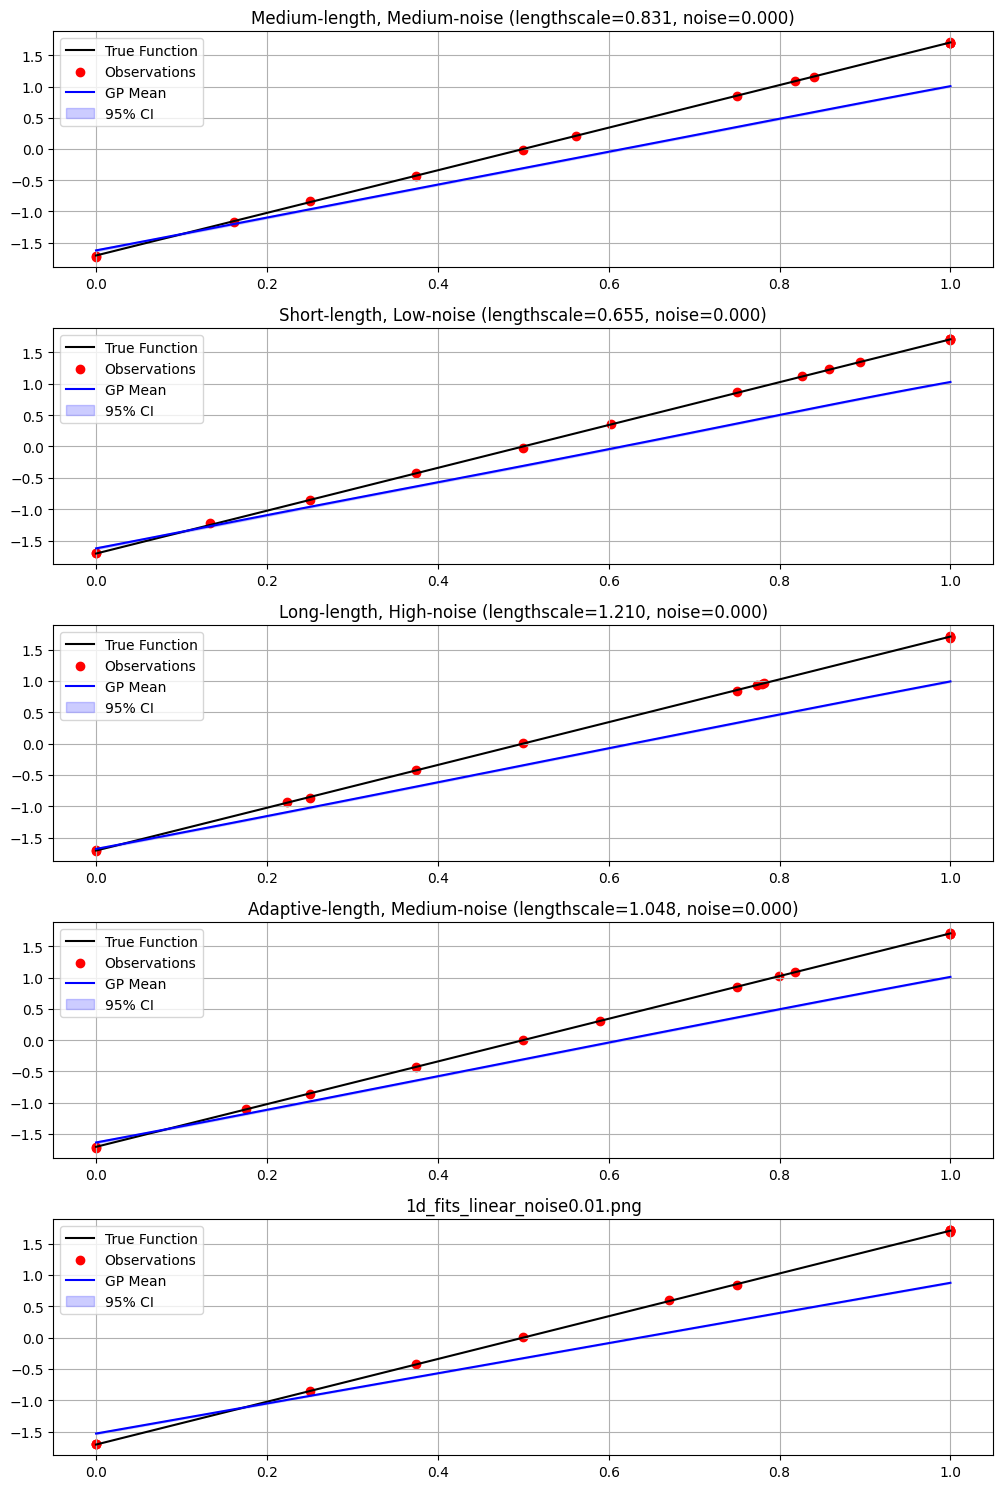


Performance Summary for linear function (dim=1, noise=0.01):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 1.7062       | 1                    | 2.6903      
Short-length, Low-noise   | 1.7062       | 1                    | 0.2350      
Long-length, High-noise   | 1.7062       | 1                    | 0.2026      
Adaptive-length, Medium-noise | 1.7062       | 1                    | 0.2260      
No prior                  | 1.7062       | 2                    | 0.2007      
Completed experiments for linear_dim1_noise0.01
Starting experiments for linear_dim1_noise0.1

Running experiments for linear function, dim=1, noise=0.1
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-length, Hig

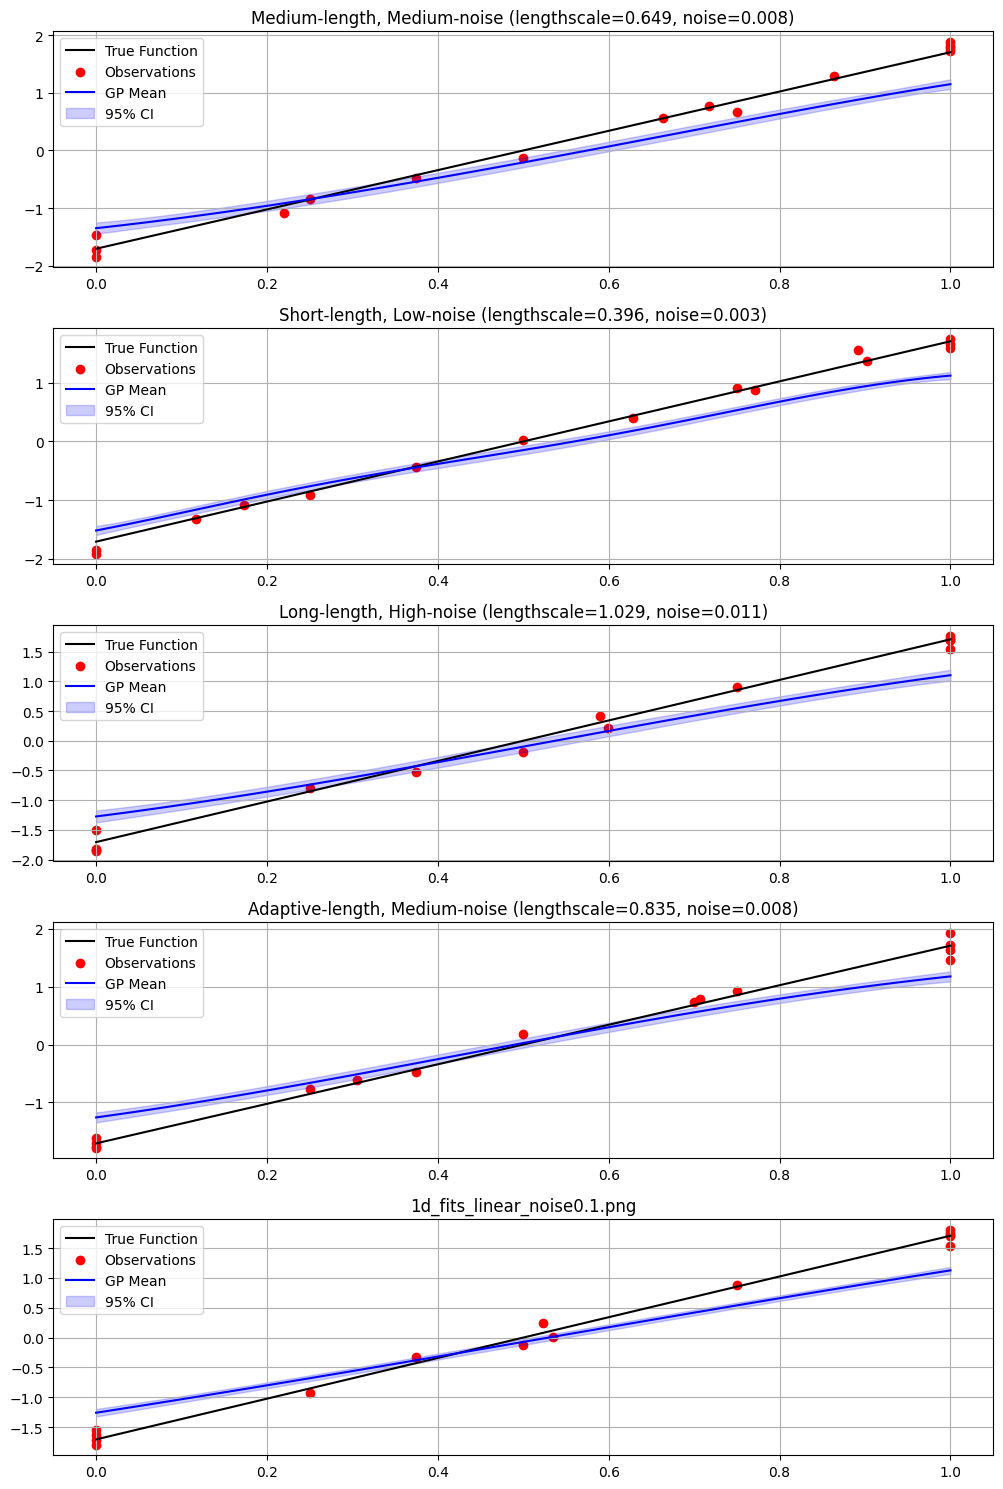


Performance Summary for linear function (dim=1, noise=0.1):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 1.7062       | 1                    | 0.1832      
Short-length, Low-noise   | 1.7062       | 1                    | 0.2157      
Long-length, High-noise   | 1.7062       | 1                    | 0.1763      
Adaptive-length, Medium-noise | 1.7062       | 1                    | 0.1822      
No prior                  | 1.7062       | 1                    | 0.1763      
Completed experiments for linear_dim1_noise0.1
Starting experiments for linear_dim1_noise0.3

Running experiments for linear function, dim=1, noise=0.3
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-length, High-

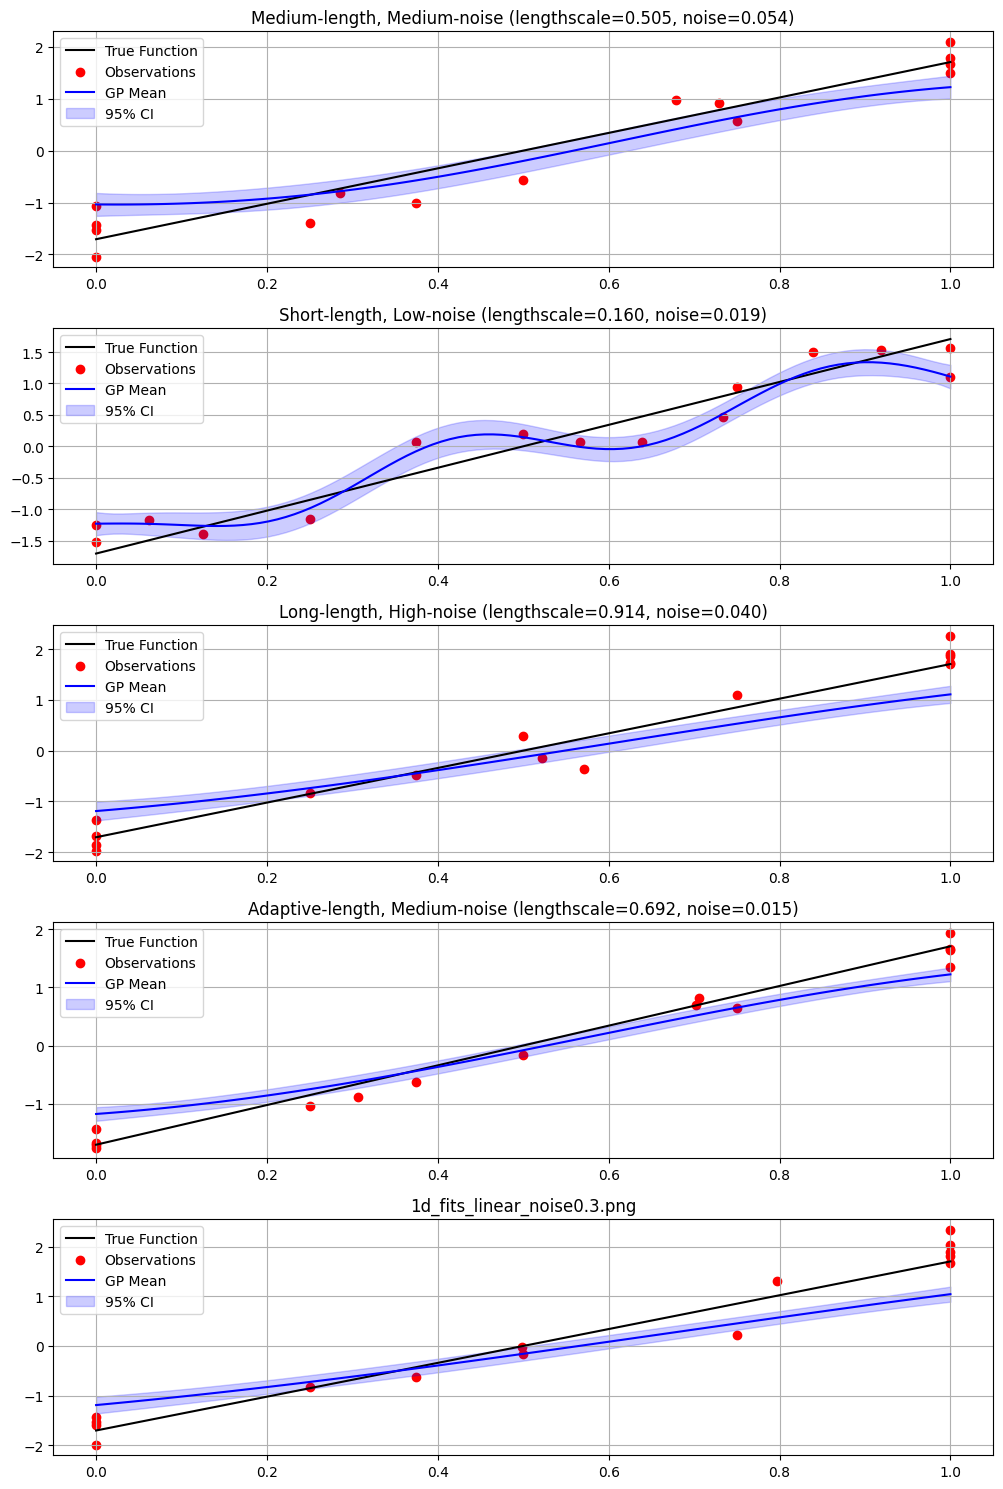


Performance Summary for linear function (dim=1, noise=0.3):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 1.7062       | 1                    | 0.1752      
Short-length, Low-noise   | 1.7062       | 4                    | 0.2379      
Long-length, High-noise   | 1.7062       | 1                    | 0.1718      
Adaptive-length, Medium-noise | 1.7062       | 1                    | 0.1814      
No prior                  | 1.7062       | 1                    | 0.1829      
Completed experiments for linear_dim1_noise0.3
Starting experiments for gaussian_dim1_noise0.01

Running experiments for gaussian function, dim=1, noise=0.01
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


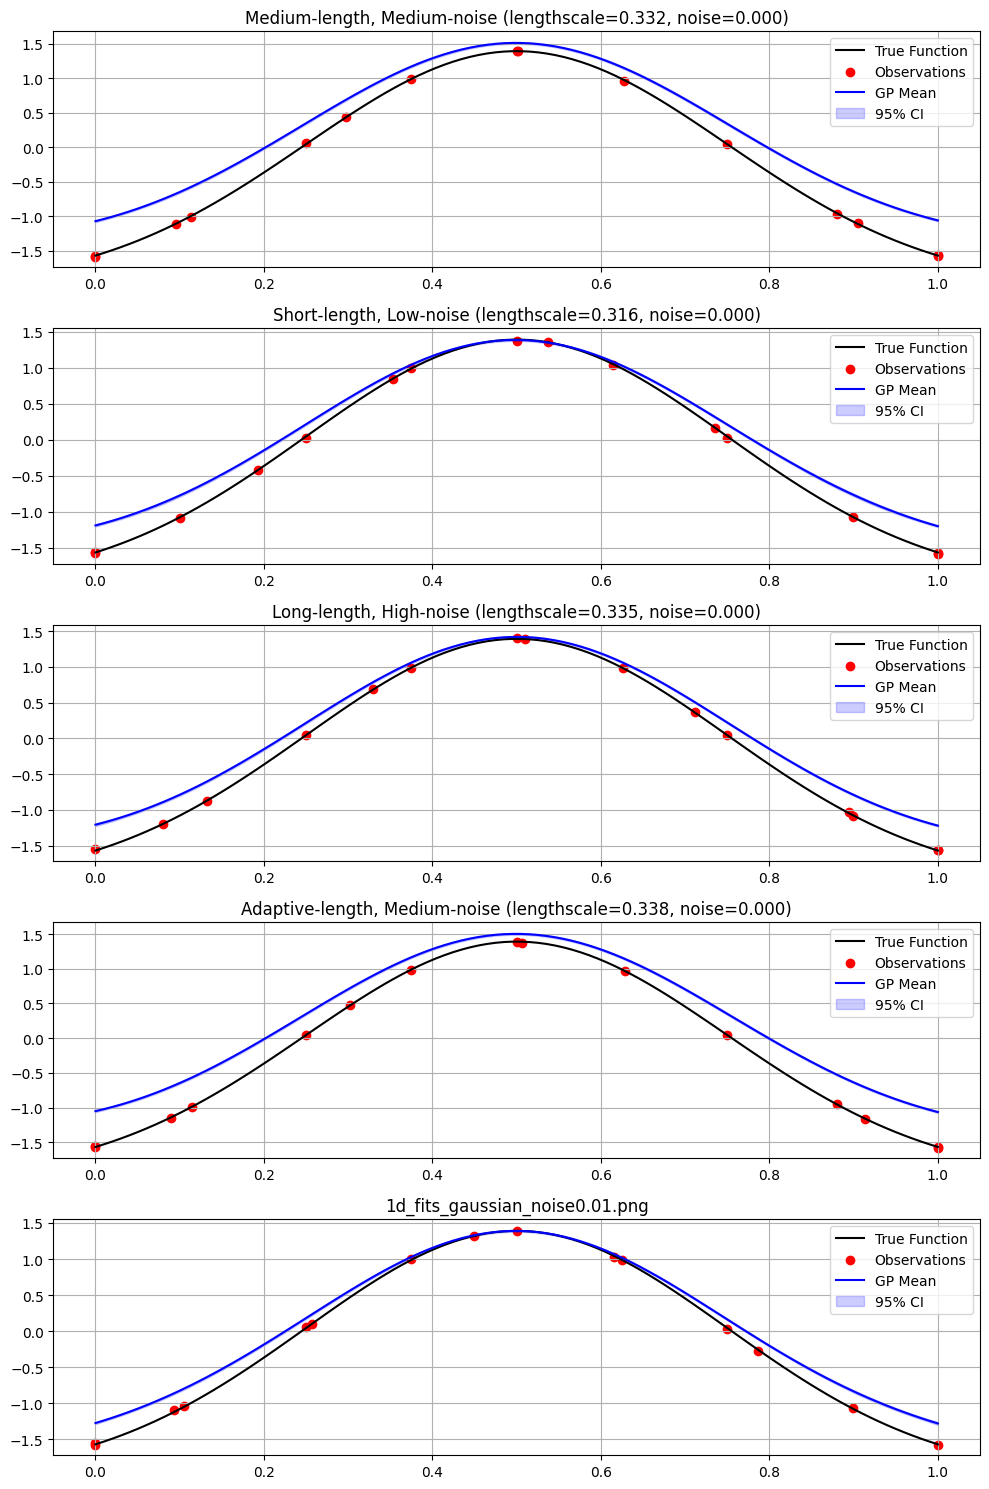


Performance Summary for gaussian function (dim=1, noise=0.01):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 1.3908       | 0                    | 0.2299      
Short-length, Low-noise   | 1.3908       | 0                    | 0.3589      
Long-length, High-noise   | 1.3908       | 0                    | 0.2401      
Adaptive-length, Medium-noise | 1.3908       | 0                    | 0.2312      
No prior                  | 1.3908       | 0                    | 0.2489      
Completed experiments for gaussian_dim1_noise0.01
Starting experiments for gaussian_dim1_noise0.1

Running experiments for gaussian function, dim=1, noise=0.1
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-len

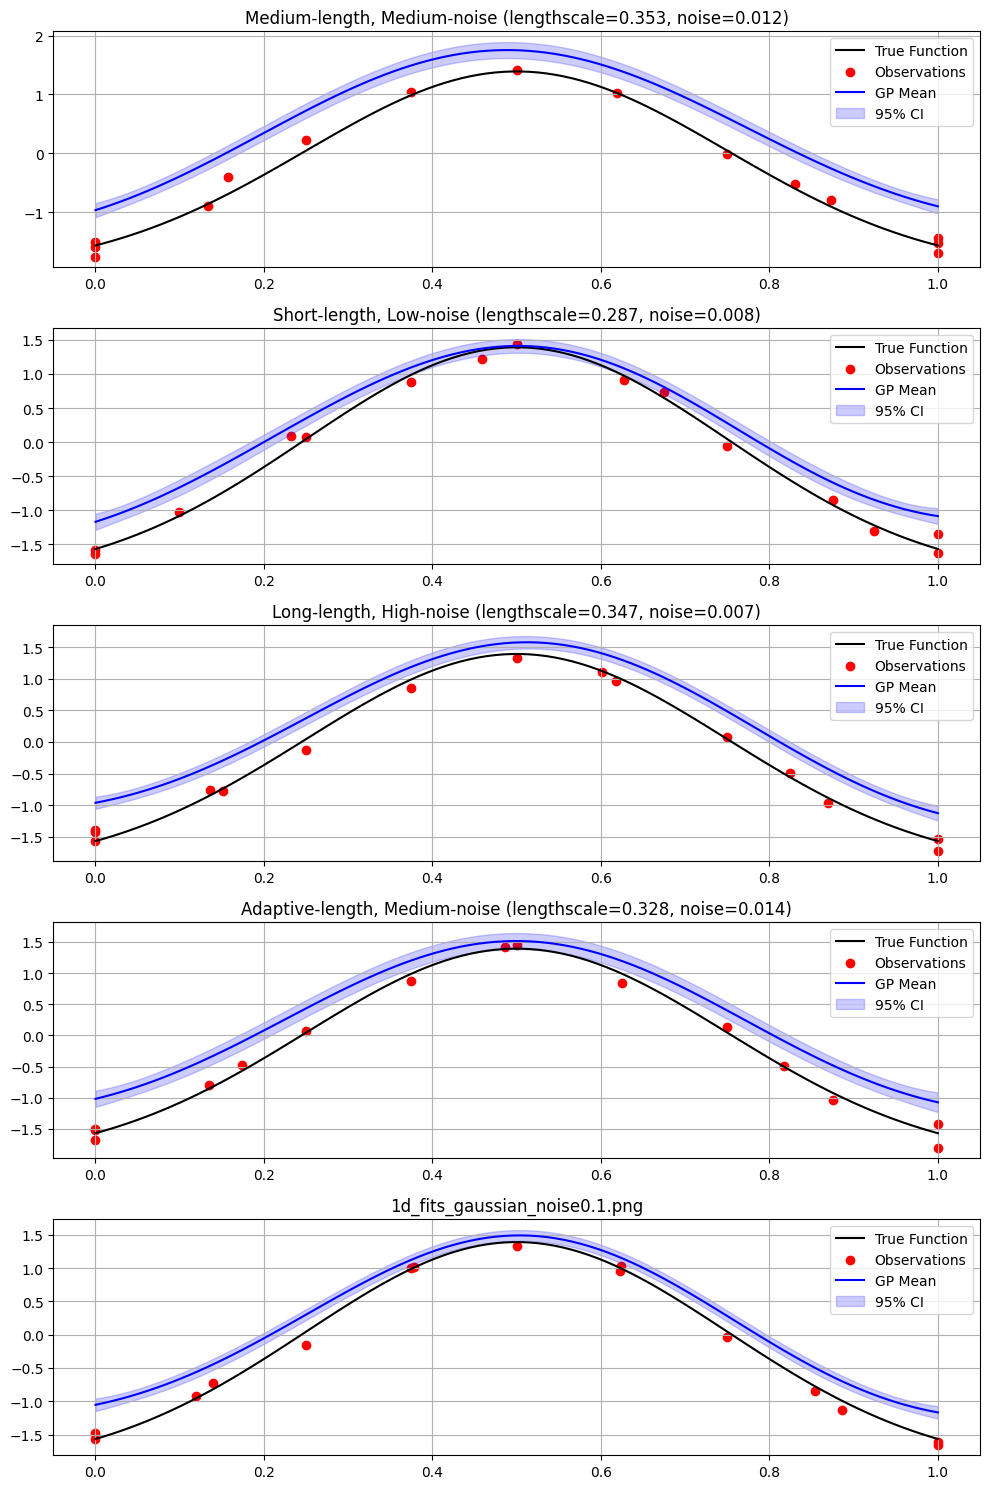


Performance Summary for gaussian function (dim=1, noise=0.1):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 1.3908       | 0                    | 0.2075      
Short-length, Low-noise   | 1.3908       | 0                    | 0.2239      
Long-length, High-noise   | 1.3908       | 0                    | 0.2044      
Adaptive-length, Medium-noise | 1.3908       | 0                    | 0.1993      
No prior                  | 1.3908       | 0                    | 0.2173      
Completed experiments for gaussian_dim1_noise0.1
Starting experiments for gaussian_dim1_noise0.3

Running experiments for gaussian function, dim=1, noise=0.3
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-lengt

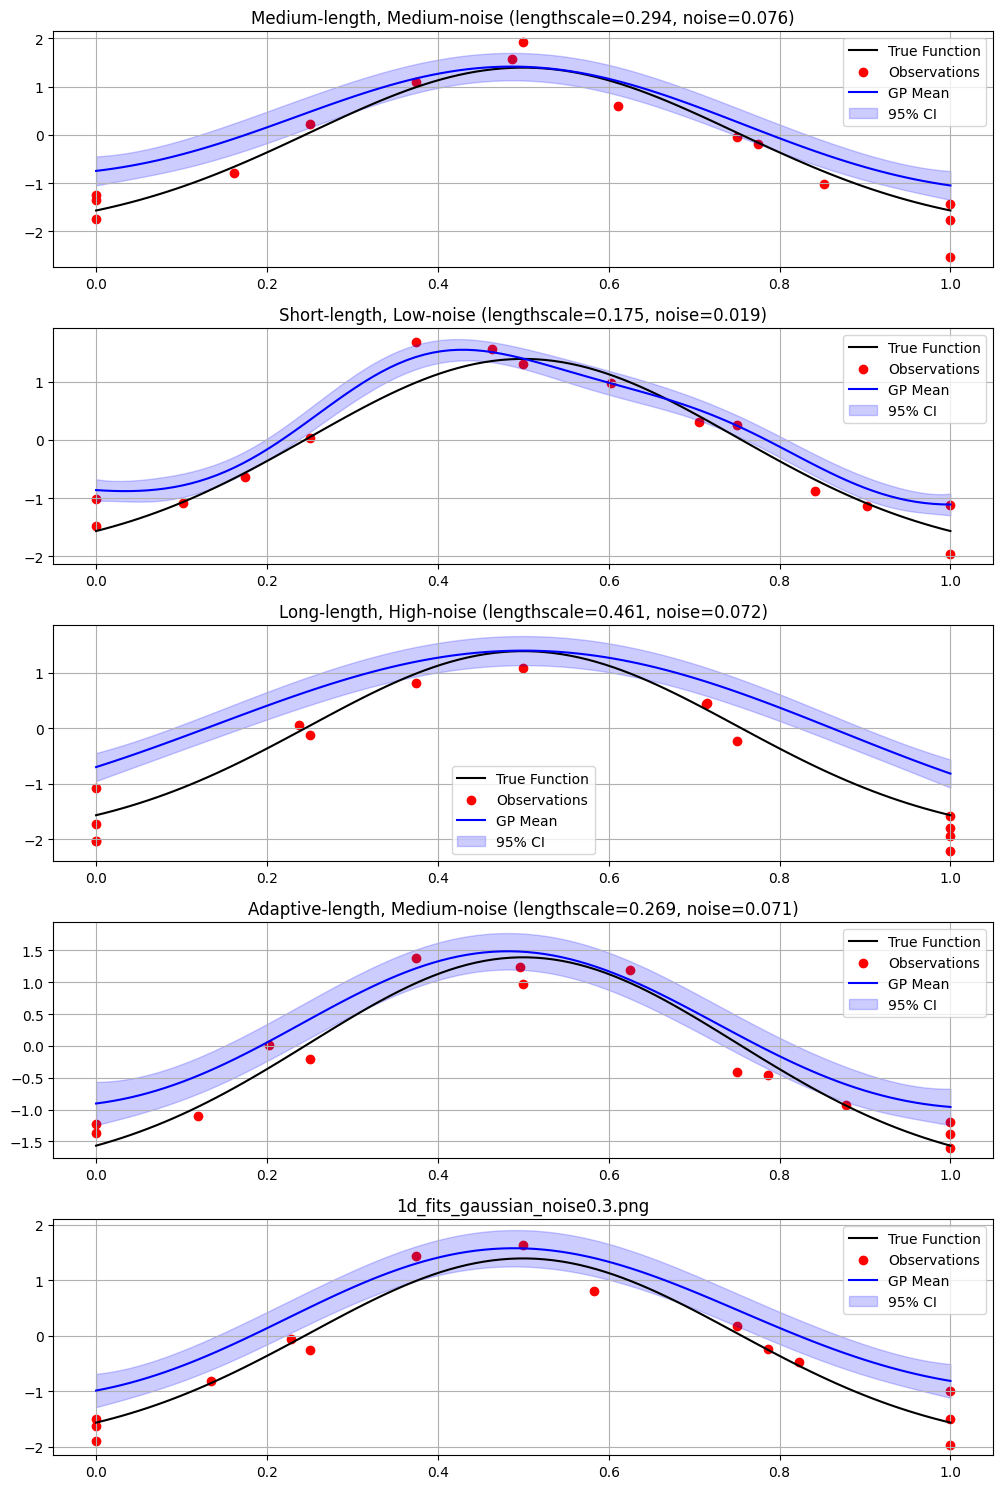


Performance Summary for gaussian function (dim=1, noise=0.3):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 1.3908       | 0                    | 0.1988      
Short-length, Low-noise   | 1.3908       | 0                    | 0.2130      
Long-length, High-noise   | 1.3908       | 0                    | 0.1990      
Adaptive-length, Medium-noise | 1.3908       | 0                    | 0.1934      
No prior                  | 1.3908       | 0                    | 0.2023      
Completed experiments for gaussian_dim1_noise0.3
Starting experiments for custom_dim1_noise0.01

Running experiments for custom function, dim=1, noise=0.01
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


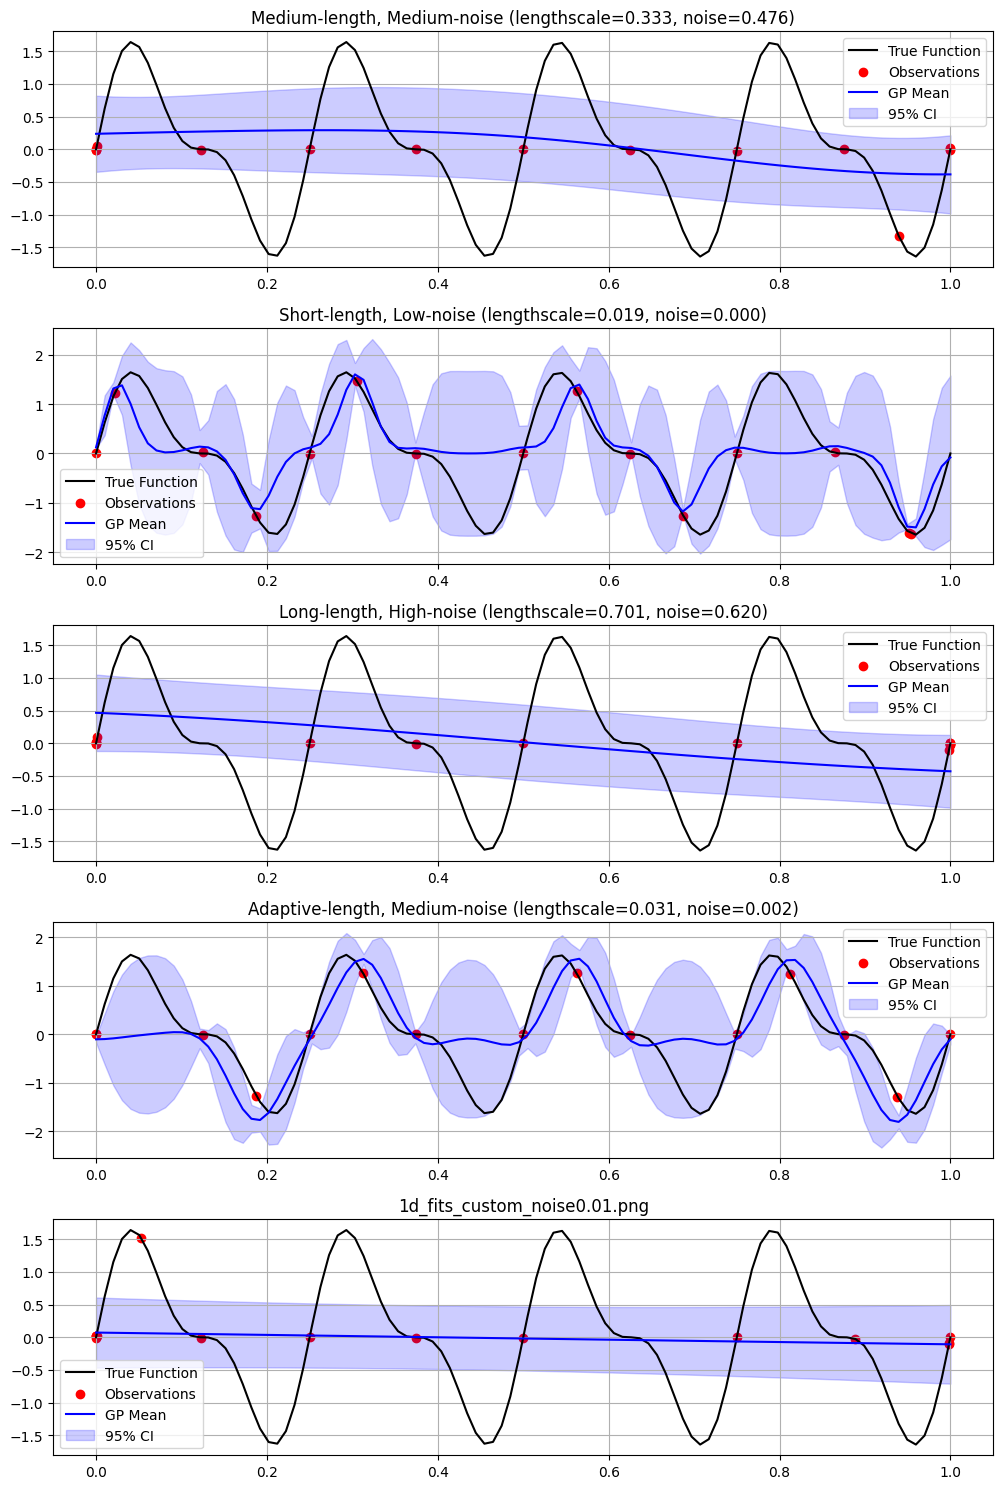


Performance Summary for custom function (dim=1, noise=0.01):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 0.0707       | N/A                  | 0.2005      
Short-length, Low-noise   | 1.4602       | 7                    | 0.3563      
Long-length, High-noise   | 0.1055       | N/A                  | 0.1708      
Adaptive-length, Medium-noise | 1.2673       | N/A                  | 0.2262      
No prior                  | 1.5224       | 3                    | 0.1911      
Completed experiments for custom_dim1_noise0.01
Starting experiments for custom_dim1_noise0.1

Running experiments for custom function, dim=1, noise=0.1
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


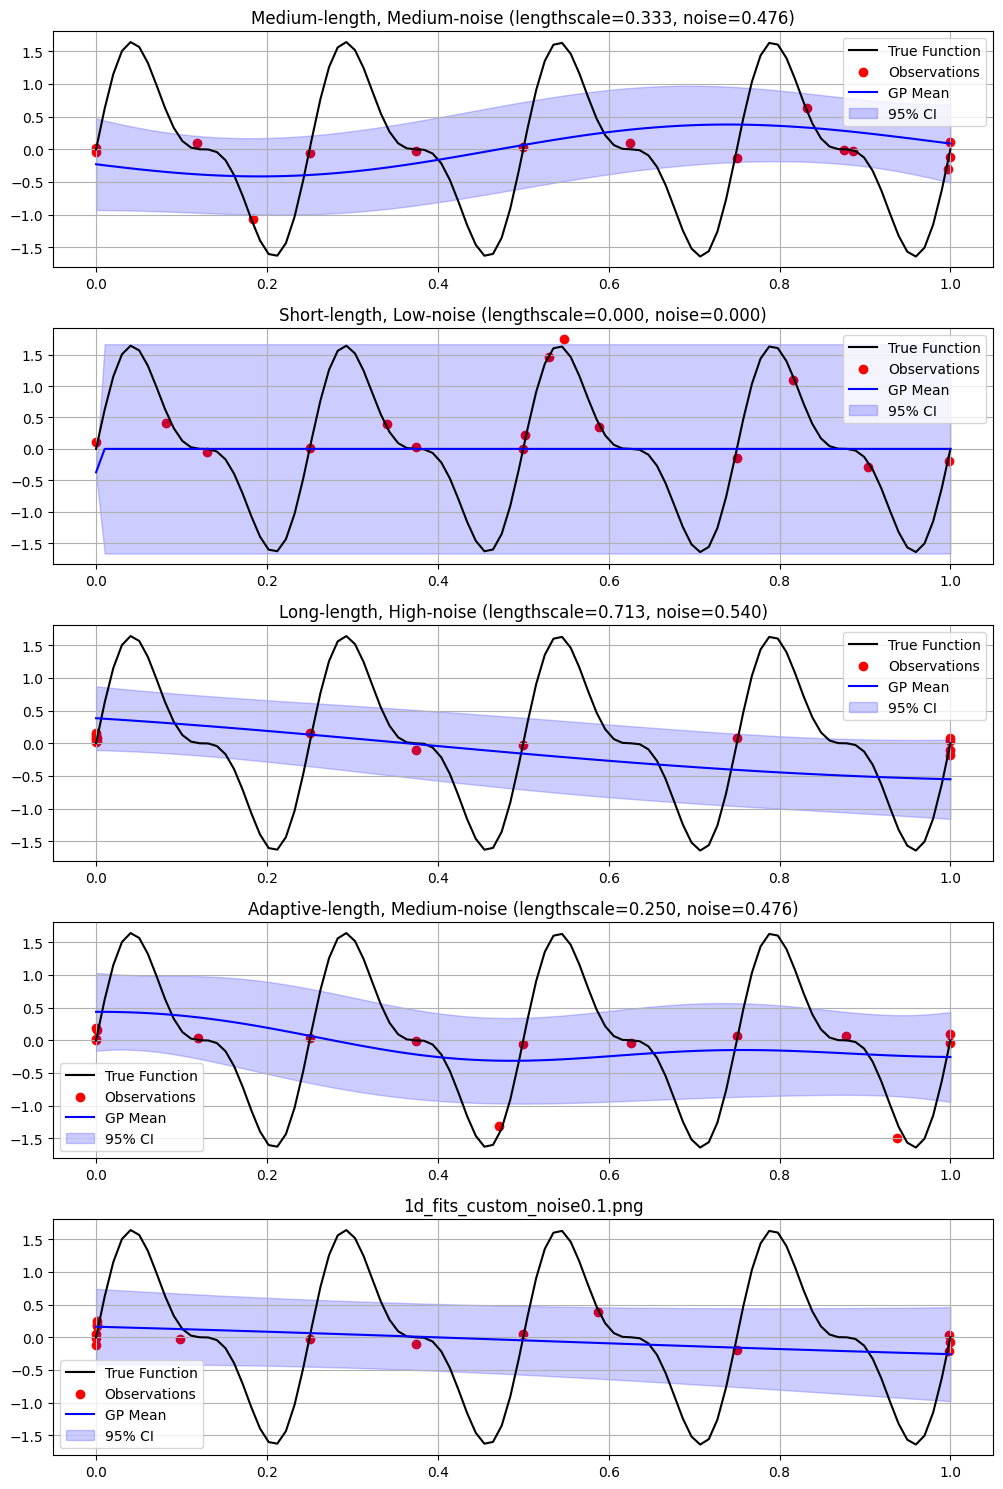


Performance Summary for custom function (dim=1, noise=0.1):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 0.6052       | N/A                  | 0.2054      
Short-length, Low-noise   | 1.6116       | 1                    | 0.4437      
Long-length, High-noise   | 0.0841       | N/A                  | 0.1898      
Adaptive-length, Medium-noise | 0.0628       | N/A                  | 0.2039      
No prior                  | 0.4083       | N/A                  | 0.1868      
Completed experiments for custom_dim1_noise0.1
Starting experiments for custom_dim1_noise0.3

Running experiments for custom function, dim=1, noise=0.3
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


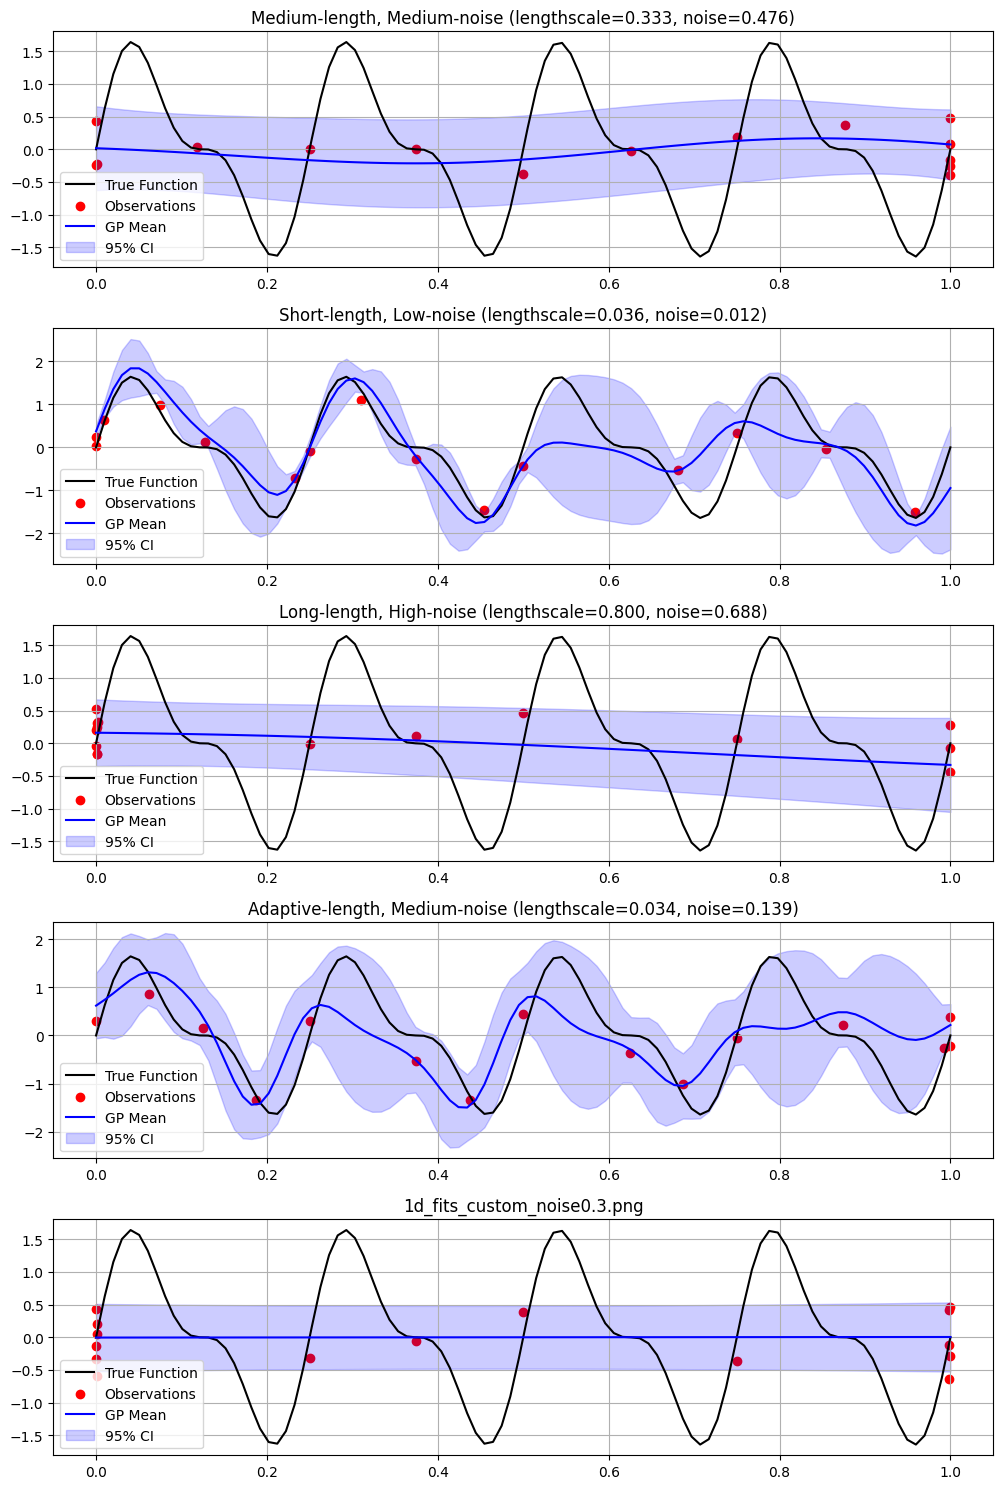


Performance Summary for custom function (dim=1, noise=0.3):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 0.1015       | N/A                  | 0.2041      
Short-length, Low-noise   | 1.3452       | 2                    | 0.6425      
Long-length, High-noise   | 0.1171       | N/A                  | 0.1995      
Adaptive-length, Medium-noise | 1.2655       | 8                    | 0.2506      
No prior                  | 0.0948       | N/A                  | 0.1778      
Completed experiments for custom_dim1_noise0.3
Starting experiments for linear_dim2_noise0.01

Running experiments for linear function, dim=2, noise=0.01
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


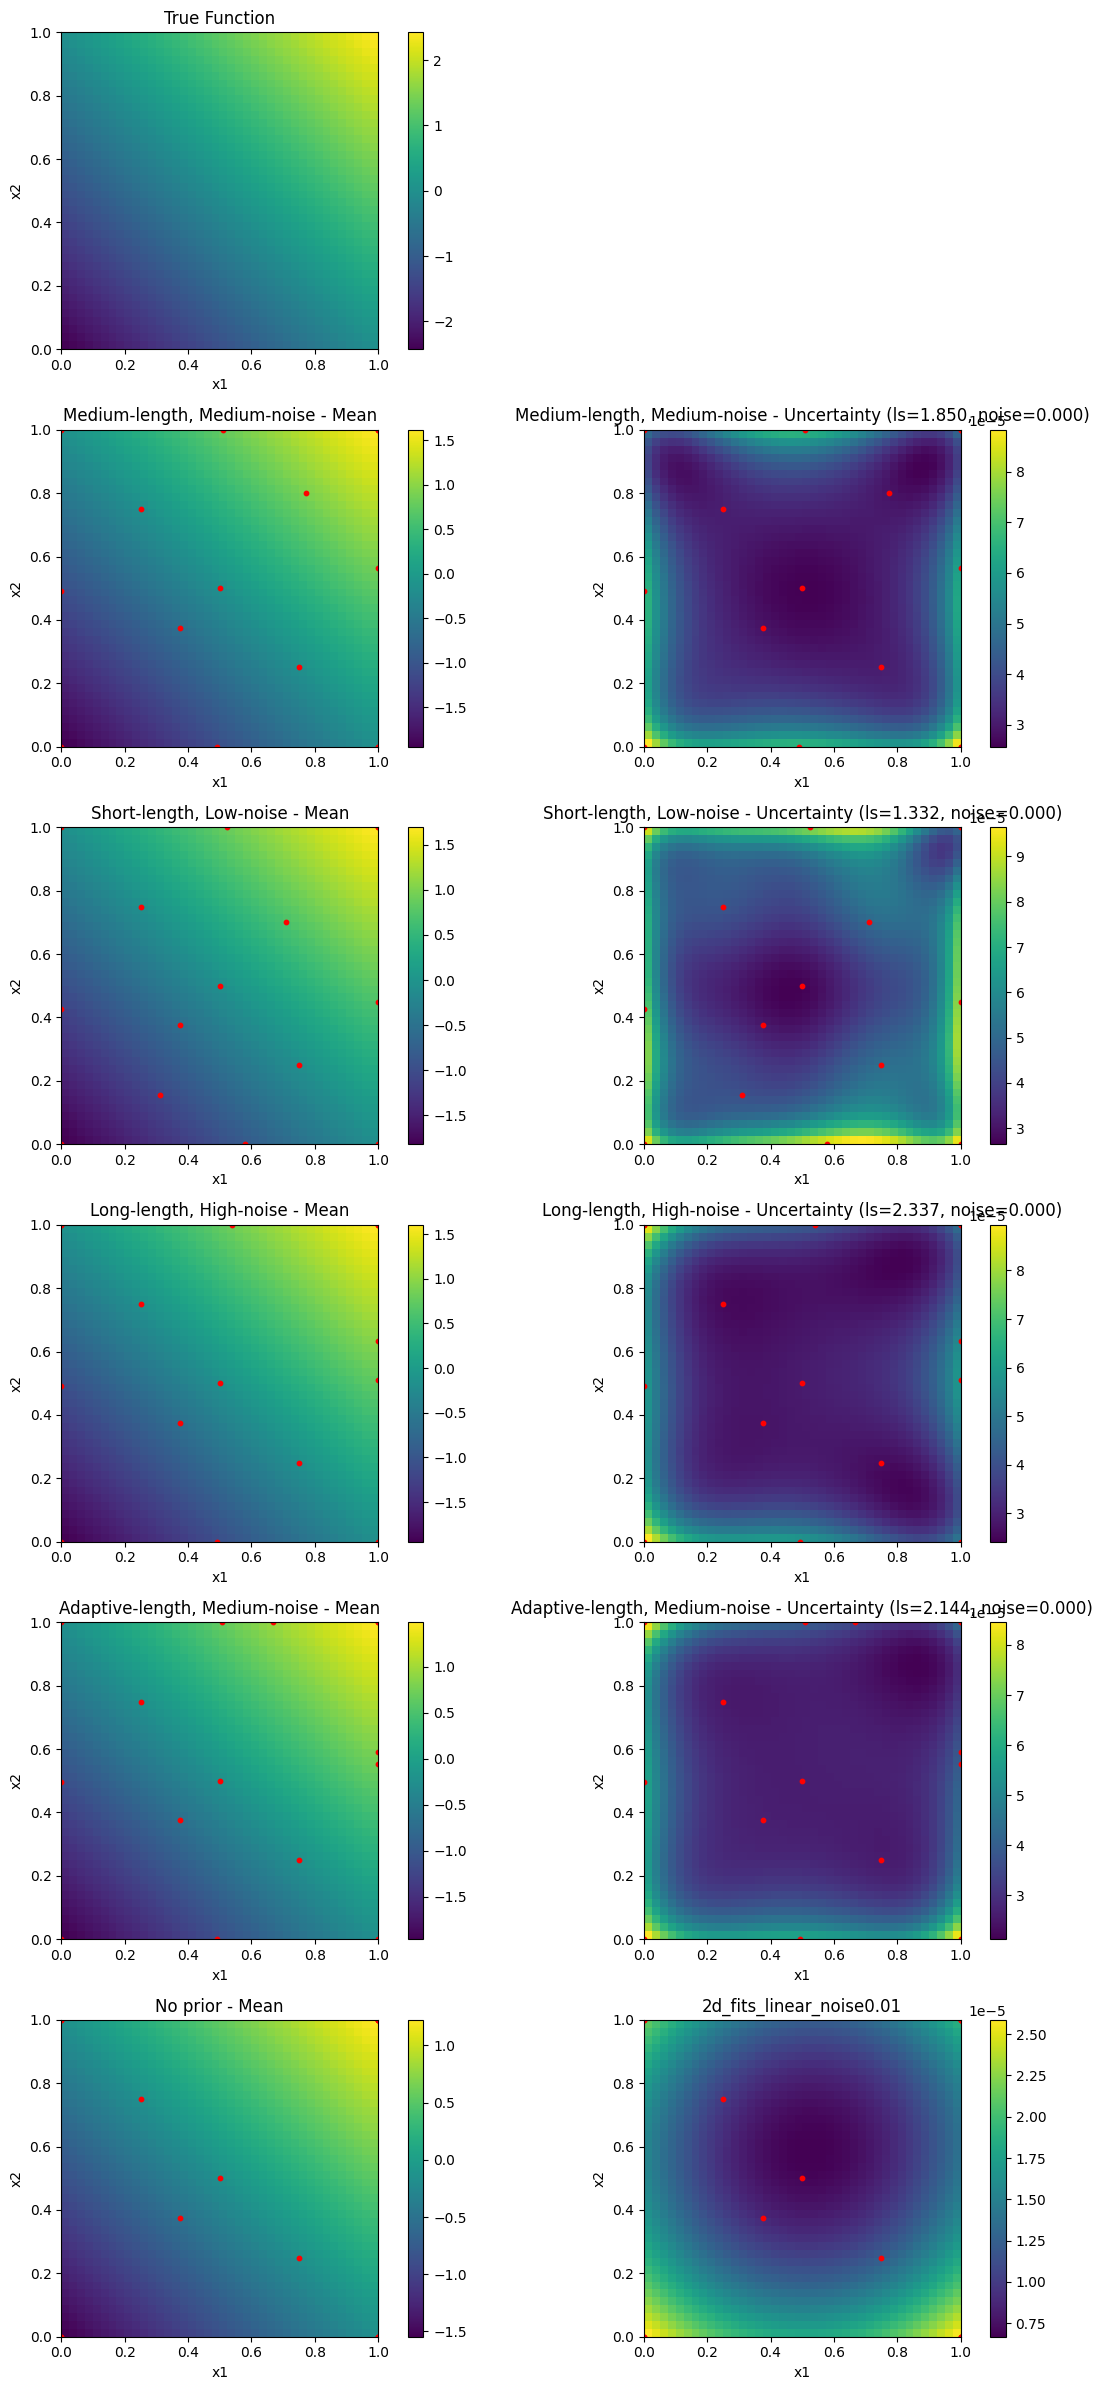


Performance Summary for linear function (dim=2, noise=0.01):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 2.4250       | 1                    | 0.2024      
Short-length, Low-noise   | 2.4250       | 3                    | 0.4441      
Long-length, High-noise   | 2.4250       | 1                    | 0.1889      
Adaptive-length, Medium-noise | 2.4250       | 1                    | 0.1971      
No prior                  | 2.4250       | 1                    | 0.2002      
Completed experiments for linear_dim2_noise0.01
Starting experiments for linear_dim2_noise0.1

Running experiments for linear function, dim=2, noise=0.1
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-length, Hig

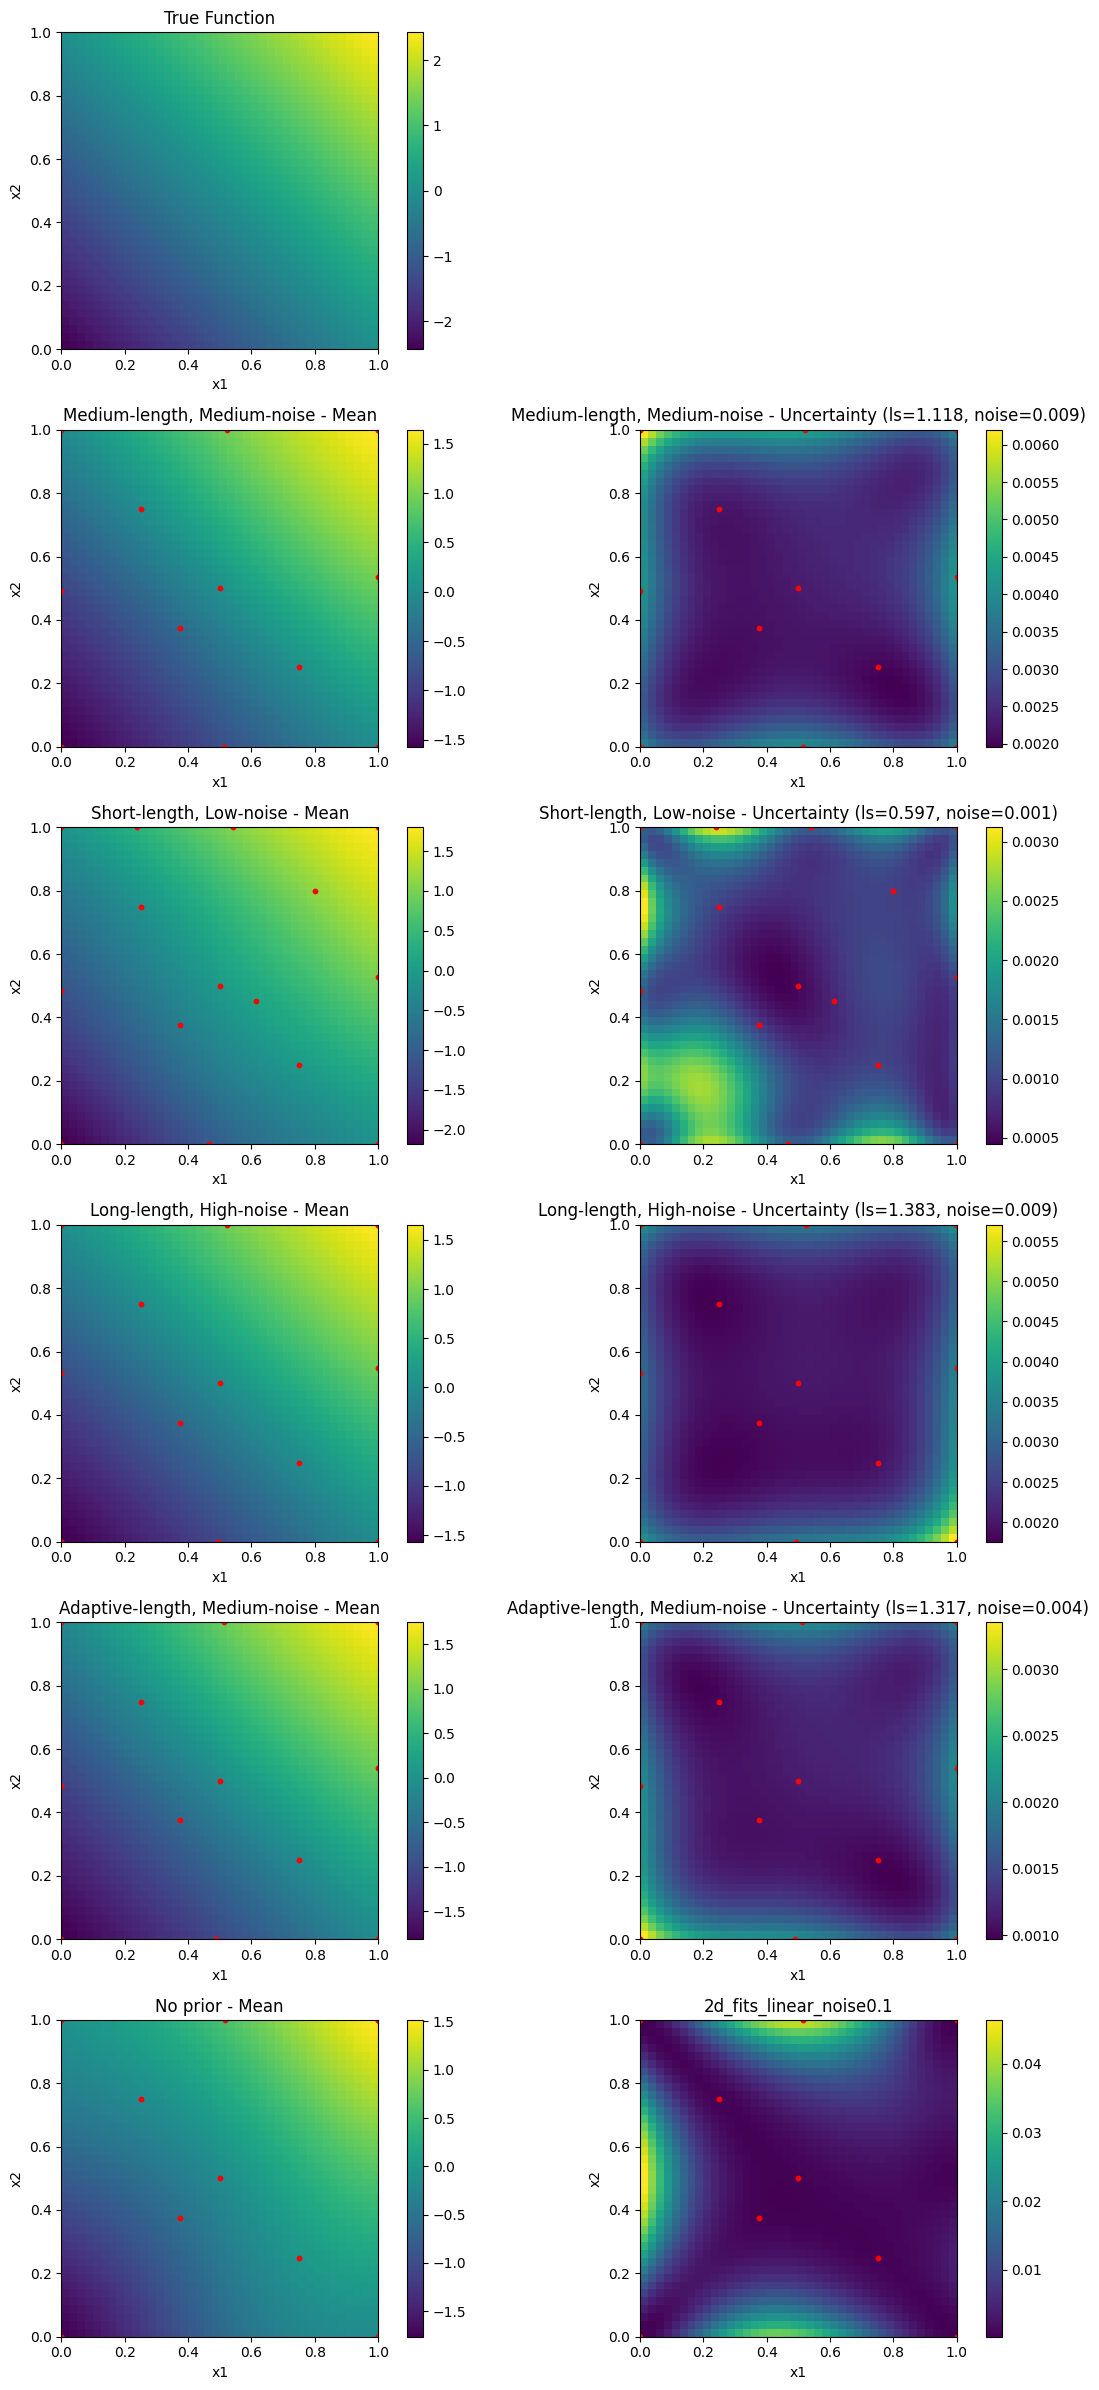


Performance Summary for linear function (dim=2, noise=0.1):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 2.4250       | 1                    | 0.1811      
Short-length, Low-noise   | 2.4250       | 2                    | 0.2281      
Long-length, High-noise   | 2.4250       | 1                    | 0.1771      
Adaptive-length, Medium-noise | 2.4250       | 1                    | 0.1978      
No prior                  | 2.4250       | 1                    | 0.1967      
Completed experiments for linear_dim2_noise0.1
Starting experiments for linear_dim2_noise0.3

Running experiments for linear function, dim=2, noise=0.3
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise
  Testing configuration: Long-length, High-

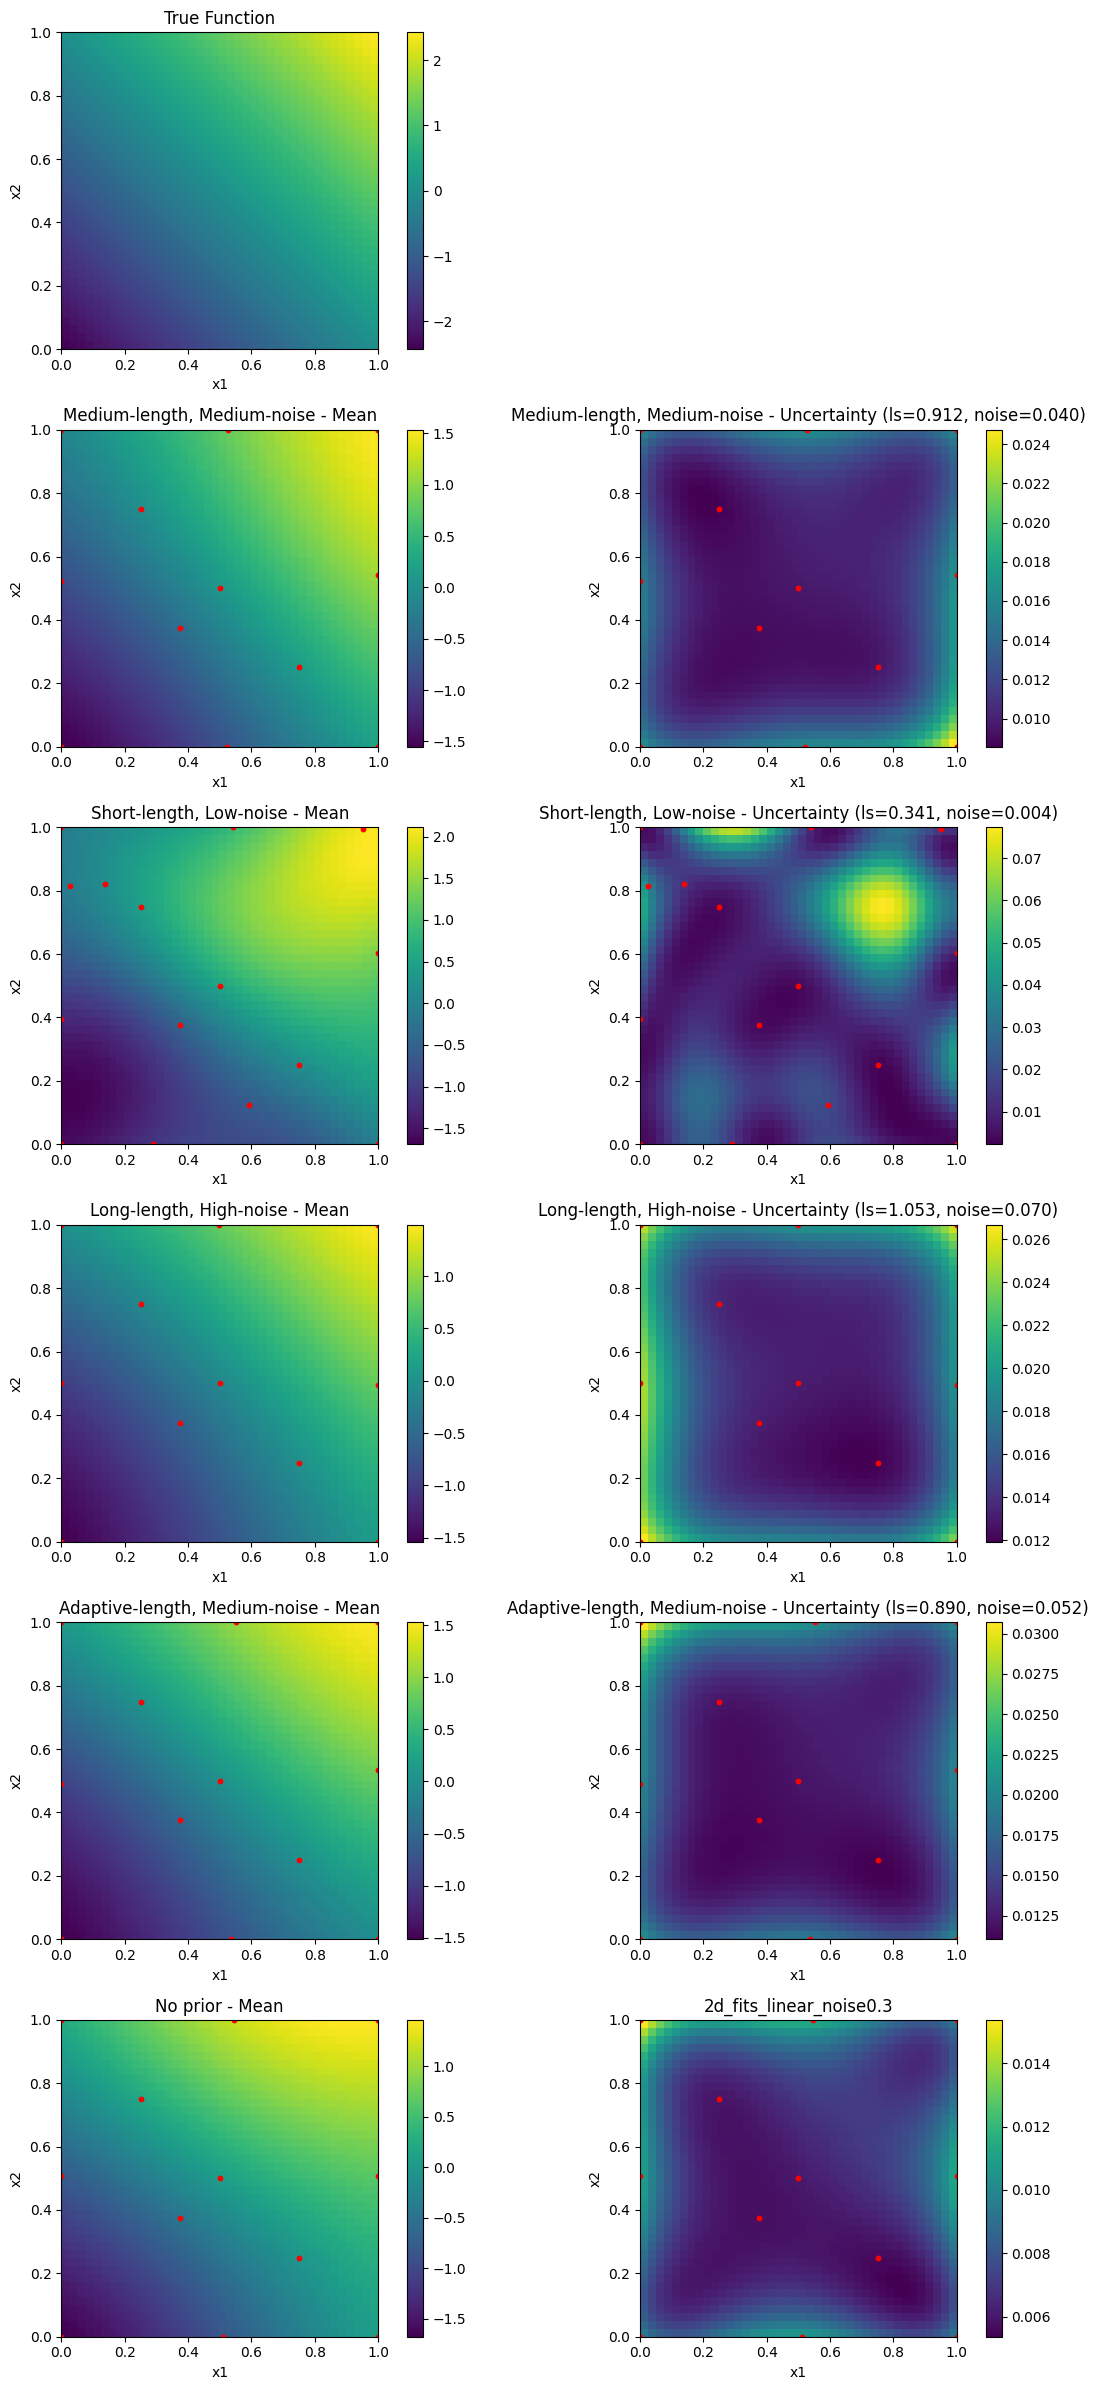


Performance Summary for linear function (dim=2, noise=0.3):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 2.4250       | 1                    | 0.1784      
Short-length, Low-noise   | 2.2950       | 4                    | 0.2047      
Long-length, High-noise   | 2.4250       | 1                    | 0.1698      
Adaptive-length, Medium-noise | 2.4250       | 1                    | 0.1725      
No prior                  | 2.4250       | 1                    | 0.1867      
Completed experiments for linear_dim2_noise0.3
Starting experiments for gaussian_dim2_noise0.01

Running experiments for gaussian function, dim=2, noise=0.01
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


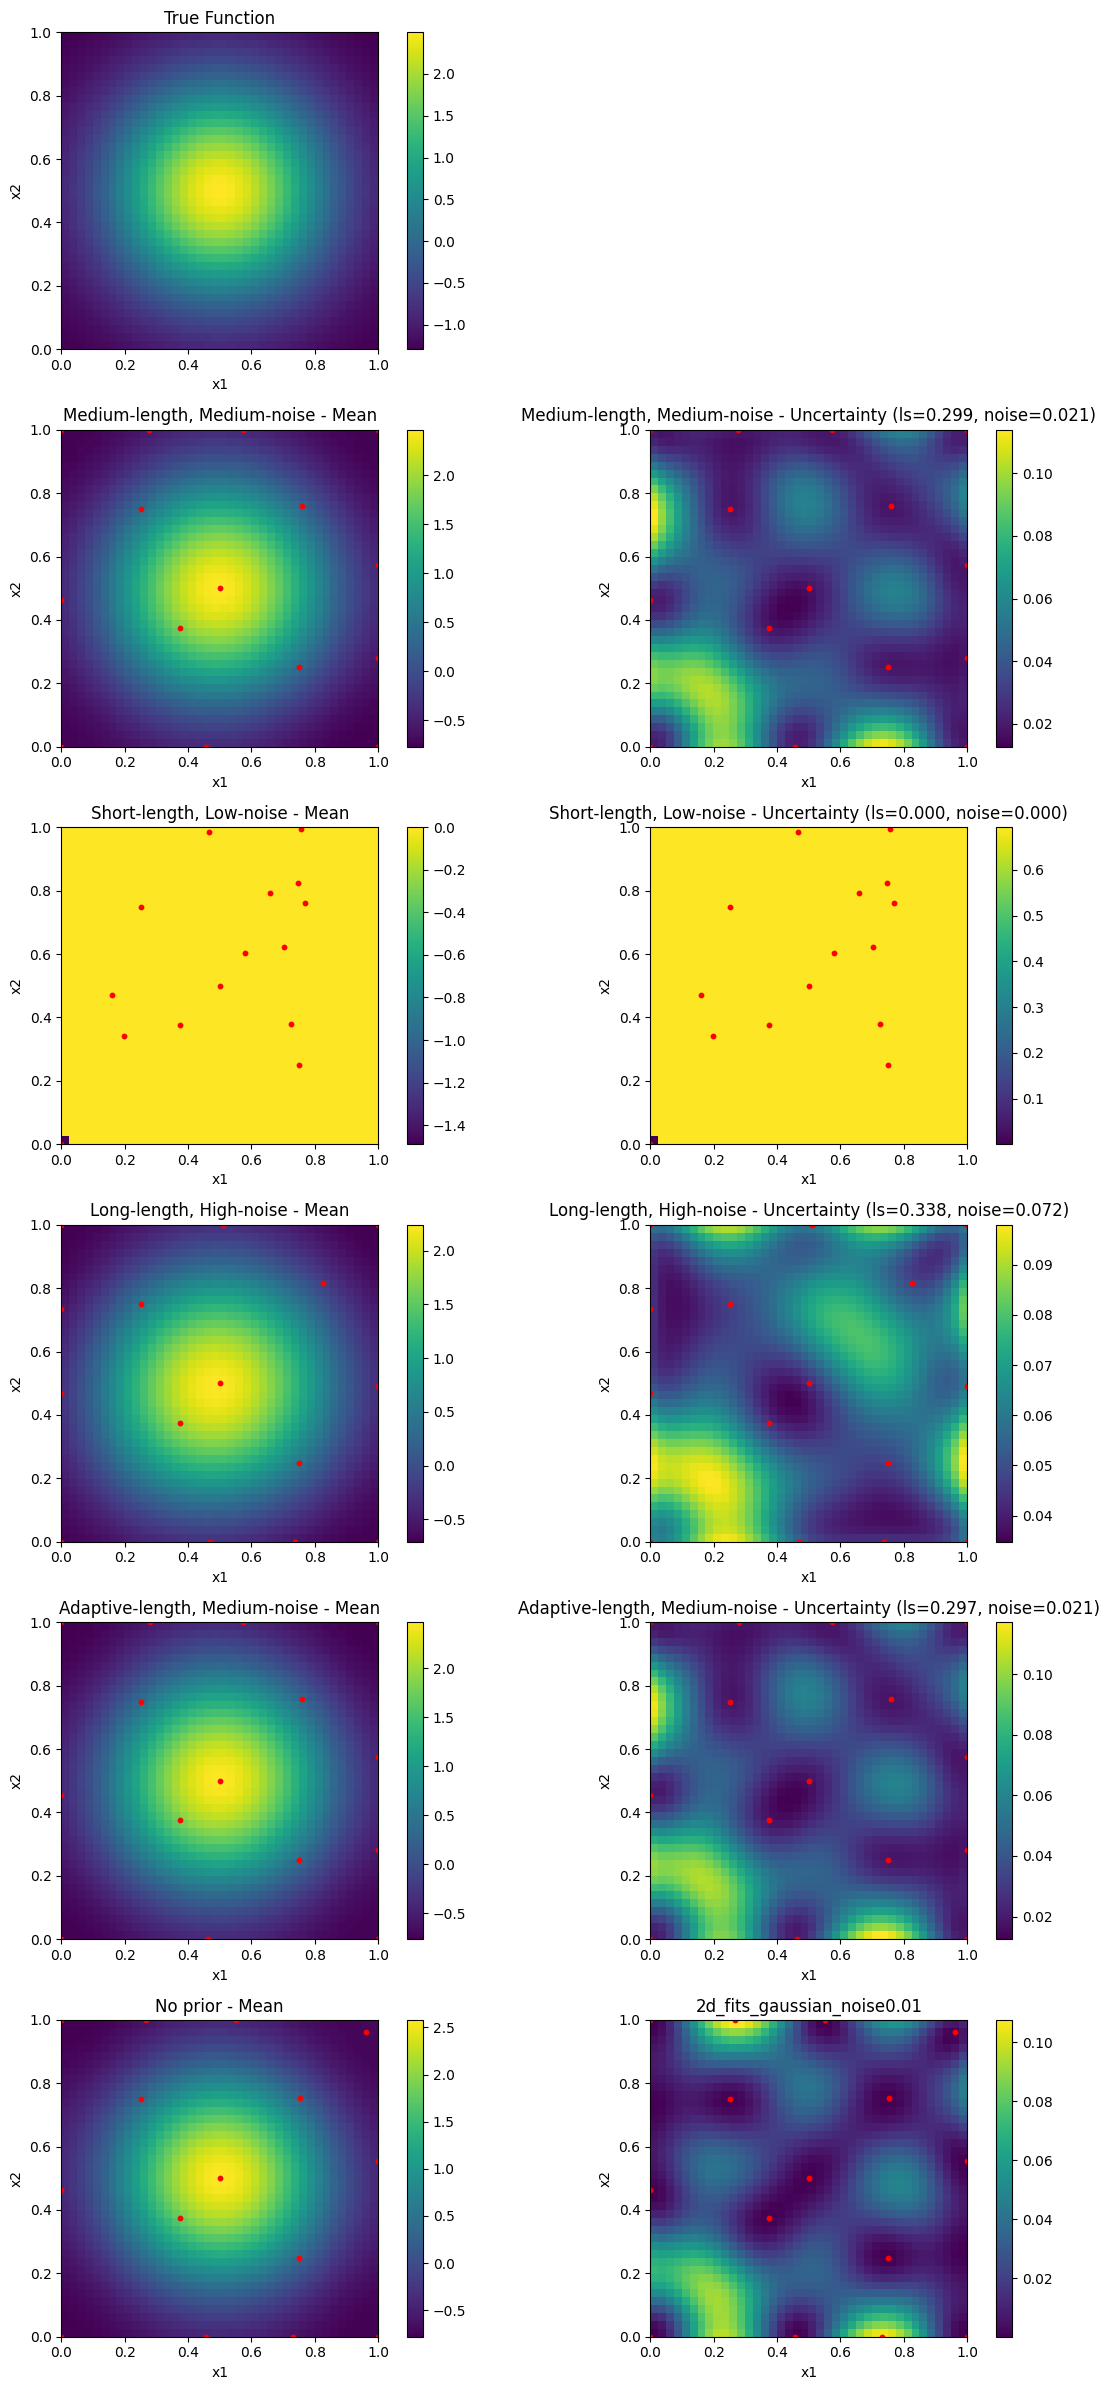


Performance Summary for gaussian function (dim=2, noise=0.01):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 2.5075       | 0                    | 0.2232      
Short-length, Low-noise   | 2.5075       | 0                    | 0.5982      
Long-length, High-noise   | 2.5075       | 0                    | 0.2056      
Adaptive-length, Medium-noise | 2.5075       | 0                    | 0.2349      
No prior                  | 2.5075       | 0                    | 0.2556      
Completed experiments for gaussian_dim2_noise0.01
Starting experiments for gaussian_dim2_noise0.1

Running experiments for gaussian function, dim=2, noise=0.1
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


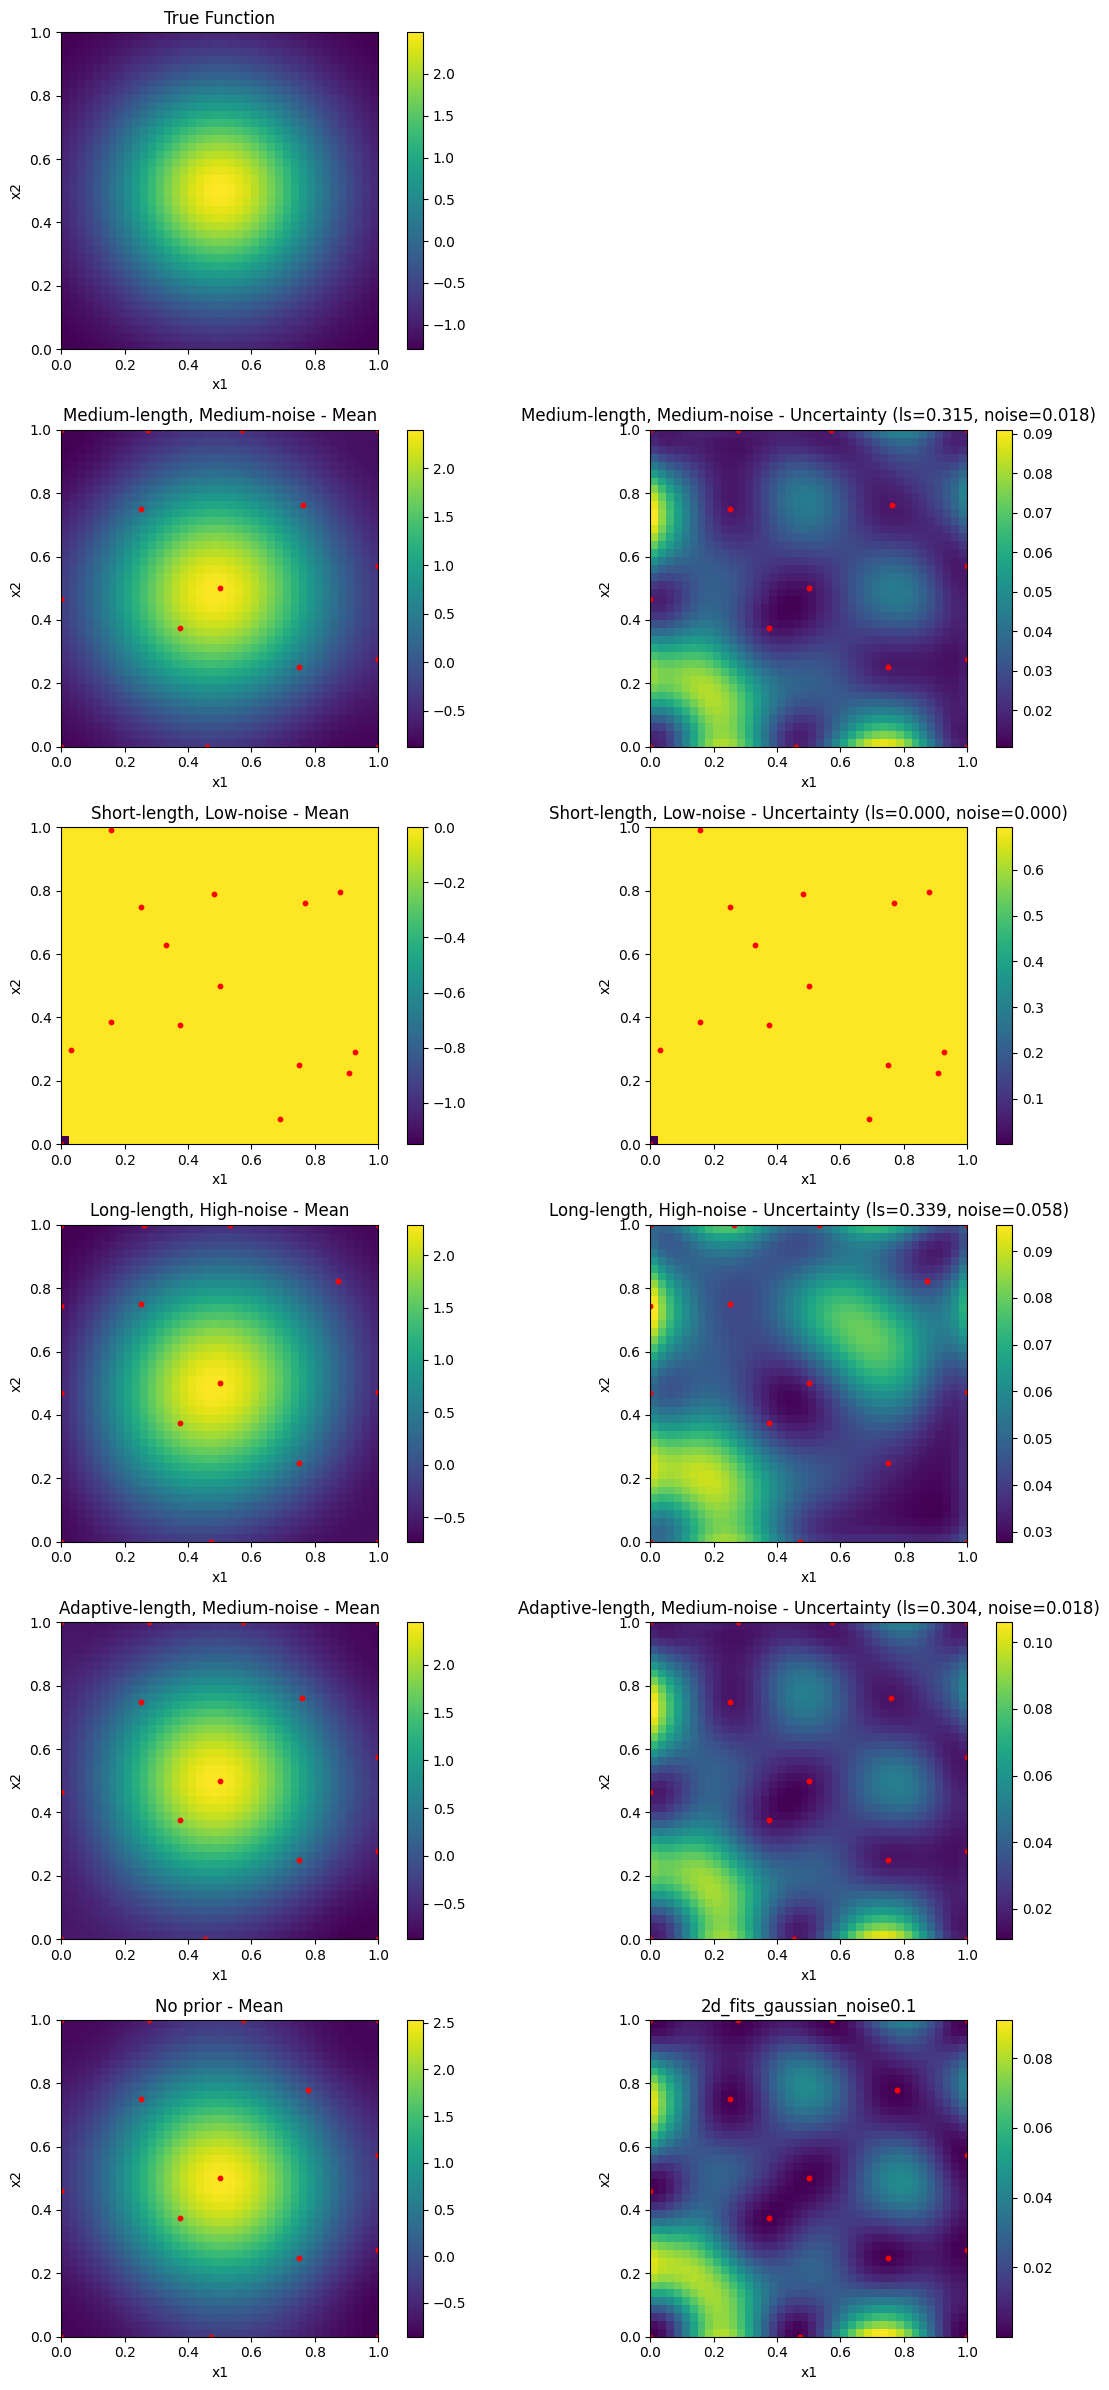


Performance Summary for gaussian function (dim=2, noise=0.1):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 2.5075       | 0                    | 0.2248      
Short-length, Low-noise   | 2.5075       | 0                    | 0.6425      
Long-length, High-noise   | 2.5075       | 0                    | 0.2128      
Adaptive-length, Medium-noise | 2.5075       | 0                    | 0.2288      
No prior                  | 2.5075       | 0                    | 0.2501      
Completed experiments for gaussian_dim2_noise0.1
Starting experiments for gaussian_dim2_noise0.3

Running experiments for gaussian function, dim=2, noise=0.3
  Testing configuration: Medium-length, Medium-noise
  Testing configuration: Short-length, Low-noise


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


  Testing configuration: Long-length, High-noise
  Testing configuration: Adaptive-length, Medium-noise
  Testing configuration: No prior


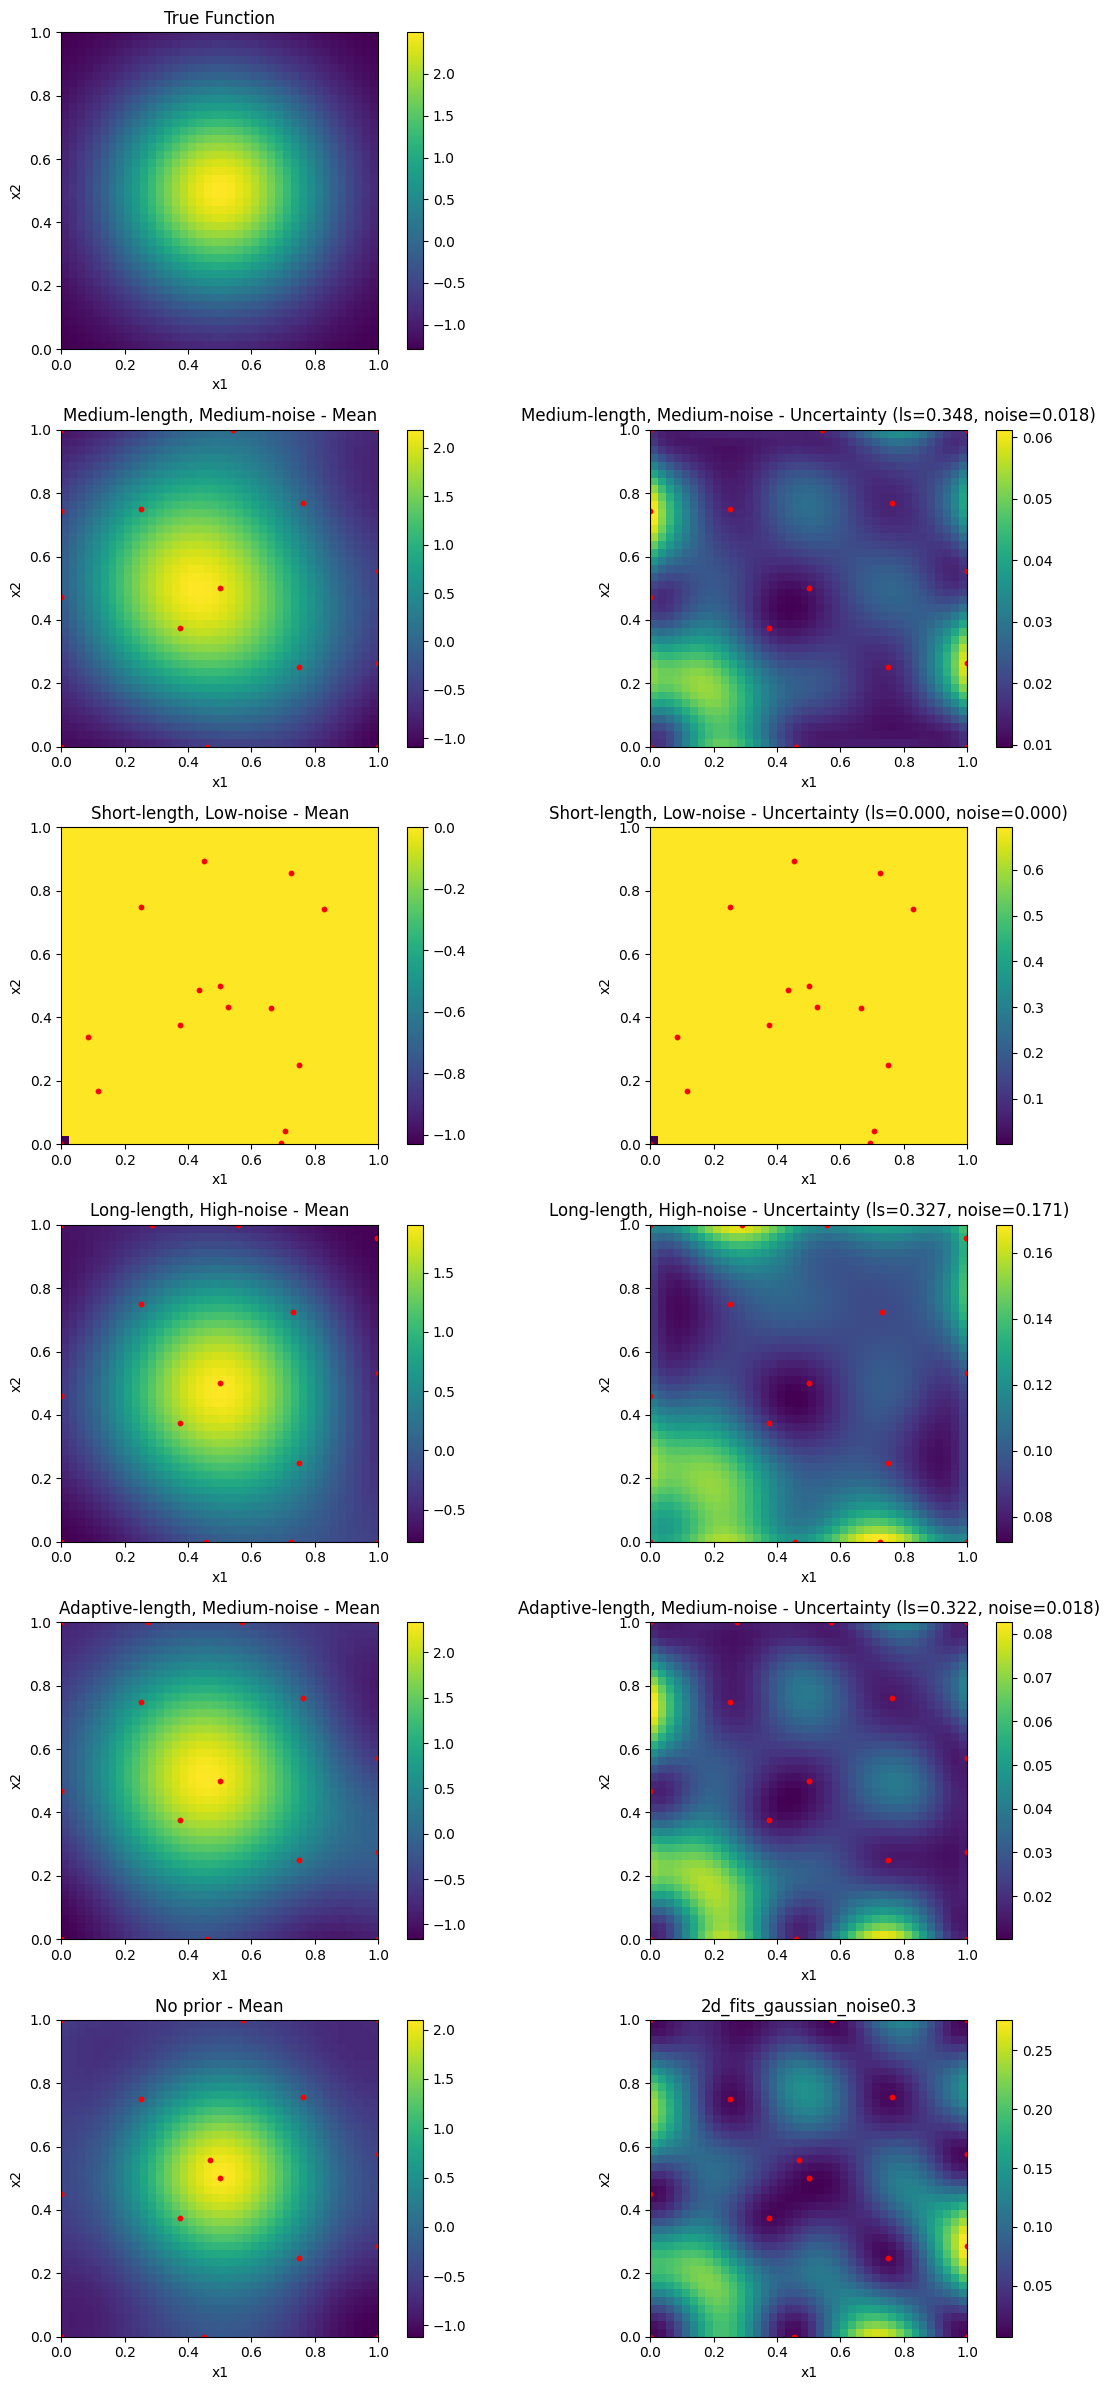


Performance Summary for gaussian function (dim=2, noise=0.3):
--------------------------------------------------------------------------------
Configuration             | Final Best   | Iterations to 90%    | Avg Time (s)
--------------------------------------------------------------------------------
Medium-length, Medium-noise | 2.5075       | 0                    | 0.2446      
Short-length, Low-noise   | 2.5075       | 0                    | 0.6558      
Long-length, High-noise   | 2.5075       | 0                    | 0.2108      
Adaptive-length, Medium-noise | 2.5075       | 0                    | 0.2144      
No prior                  | 2.5075       | 0                    | 0.2344      
Completed experiments for gaussian_dim2_noise0.3
Starting experiments for custom_dim2_noise0.01

Running experiments for custom function, dim=2, noise=0.01
  Testing configuration: Medium-length, Medium-noise


In [ ]:
# Define dimensions, function types, and noise levels to test
dimensions = [1, 2]
function_types = ["linear", "gaussian", "custom"]
noise_levels = [0.01, 0.1, 0.3]  # Low, medium, high noise

prior_configs = get_prior_configurations(dim=1)  # Dimension-agnostic priors

all_experiment_results = {}

for dim in dimensions:
    for function_type in function_types:
        for noise_level in noise_levels:
            key = f"{function_type}_dim{dim}_noise{noise_level}"
            print(f"Starting experiments for {key}")
            print(f"\nRunning experiments for {function_type} function, dim={dim}, noise={noise_level}")
            all_experiment_results[key] = {}
            
            if function_type == "linear":
                test_function = generate_test_function("linear", dim)
            elif function_type == "gaussian":
                # Width = 1/4 of domain size as suggested
                test_function = generate_test_function("gaussian", dim, width=0.25)
            elif function_type == "custom":
                test_function = generate_test_function("custom", dim)
            
            for lengthscale_prior, noise_prior, config_name in prior_configs:
                print(f"  Testing configuration: {config_name}")
                
                results = run_bo_experiment(
                    test_function=test_function,
                    dim=dim,
                    n_initial=5,  # As specified
                    n_iterations=10,  # As specified
                    lengthscale_prior=lengthscale_prior,
                    noise_prior=noise_prior,
                    noise_level=noise_level
                )
                
                all_experiment_results[key][config_name] = results
            
            visualize_experiments(
                all_results=all_experiment_results[key],
                function_type=function_type,
                dim=dim,
                noise_level=noise_level
            )
            print(f"Completed experiments for {key}")

